In [1]:
from functools import partial

import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import math
import datetime

from timm.models.vision_transformer import Block
from model_mae import MaskedAutoencoder
from utils import MaskEmbed, get_1d_sincos_pos_embed, ActiveEmbed, Utils
from datasets import load_dataset

eps = 1e-6

/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(L == self.rec_len, f"Input data width ({L}) doesn't match model ({self.rec_len}).")


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

In [3]:
device

device(type='cuda', index=1)

In [4]:
path = "."
data_path = "./data/"
filename = "TransferLearningData.csv"
model_dir = "./model/"
log_dir = "./log/"

In [5]:
# Supply the wandb parameters, like project, run name
wandb_project = "mae"
wandb_run = "masking_{}_{}".format(str(datetime.datetime.now().date()), str(datetime.datetime.now().time()))
save_code = True

In [6]:
pre_train_window = 35
non_null_ratio = 0.20

'''
learning rate scheduler parameters
'''
max_lr=5e-2
div_factor=100
pct_start=0.05 
anneal_strategy='cos'
final_div_factor=10000.0

In [7]:
filepath = os.path.join(data_path, filename)
df = pd.read_csv(filepath)

/tmp/ipykernel_50559/2703397818.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [8]:
df

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,21.69000,2.576500,0.001250,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,21.19500,1.132500,0.003451,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,20.29000,1.154821,0.005080,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,23.55500,1.177141,0.003196,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,24.73000,1.199462,0.001073,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70835,TOOK,2022-12-27,buoy,0.5,observed,NaN,-35.39290,-0.740000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70836,TOOK,2022-12-28,buoy,0.5,observed,NaN,-29.69685,0.575000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70837,TOOK,2022-12-29,buoy,0.5,observed,NaN,-22.03290,-0.675000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70838,TOOK,2022-12-30,buoy,0.5,observed,NaN,-13.60220,-0.980000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN


In [9]:
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [10]:
cols_to_exclude_from_features = ["Lake","Site","Depth_m","DataType","ModelRunType"]
features_col = df.columns.difference(cols_to_exclude_from_features)
features_col = [feat for feat in features_col if not 'flag' in feat.lower() and feat!='DateTime']
features_col

['AirTemp_C',
 'Chla_ugL',
 'DIN_ugL',
 'Inflow_cms',
 'LightAttenuation_Kd',
 'SRP_ugL',
 'Shortwave_Wm2',
 'WaterTemp_C']

In [11]:
# df = df.dropna(subset=features_col)
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [12]:
for lake in df.Lake.unique():
    lake_df = df[df['Lake']==lake]
    print(f"Lake {lake} has types = {lake_df.DataType.unique()}")

Lake FCR has types = ['observed' 'modeled']
Lake Mendota has types = ['modeled']
Lake Sunapee has types = ['modeled']
Lake BARC has types = ['observed']
Lake CRAM has types = ['observed']
Lake LIRO has types = ['observed']
Lake PRLA has types = ['observed']
Lake PRPO has types = ['observed']
Lake SUGG has types = ['observed']
Lake TOOK has types = ['observed']


In [13]:
date_col = ['DateTime']
date_col

['DateTime']

In [14]:
df.DateTime = df.DateTime.astype('datetime64[ns]')

In [15]:
# get the observed values
train_df = df.copy(deep=True)

In [16]:
flag_cols = [col for col in train_df.columns if col.startswith('Flag')]

In [17]:
num_features = len(features_col)
utils = Utils(num_features=num_features,
              inp_cols=features_col, 
              date_col=date_col, 
              window=pre_train_window, 
              flag_cols=flag_cols,
              non_null_ratio=non_null_ratio,
              device=device,
              stride=1)

In [18]:
train_set = pd.DataFrame()
val_set = pd.DataFrame()

for lake in train_df.Lake.unique():
    lake_df = train_df[train_df['Lake']==lake].reset_index(drop='true')
    types = lake_df.DataType.unique()
    for dtype in types:
        lake_type_df = lake_df[lake_df['DataType']==dtype].reset_index(drop='true')
        train, val = utils.train_test_split(lake_type_df, split_type=None, split_date=None, split_ratio=0.8)
        train_set = train_set.append(train, ignore_index=True)
        val_set = val_set.append(val, ignore_index=True)

/tmp/ipykernel_50559/3497671915.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(train, ignore_index=True)
/tmp/ipykernel_50559/3497671915.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_set = val_set.append(val, ignore_index=True)


In [20]:
train_path = os.path.join(data_path, f'unnorm_train_{pre_train_window}.pth')
val_path = os.path.join(data_path, f'unnorm_val_{pre_train_window}.pth')

if os.path.exists(train_path):
    train_X = torch.load(train_path)
else:
    train_X = utils.windowed_dataset_utils(train_set)
    torch.save(train_X, train_path)

if os.path.exists(val_path):
    val_X = torch.load(val_path)
else:
    val_X = utils.windowed_dataset_utils(val_set)
    torch.save(val_X, val_path)

In [21]:
train_X = torch.from_numpy(train_X).type(torch.Tensor)
val_X = torch.from_numpy(val_X).type(torch.Tensor)

train_X = utils.normalize_tensor(train_X, use_stat=False)
val_X = utils.normalize_tensor(val_X, use_stat=True)

train_X = train_X.transpose(1, 2)
val_X = val_X.transpose(1, 2)

# Masked Pre-training

In [22]:
model_args = {
    'num_feats':num_features,
    'rec_len': pre_train_window,
    'embed_dim': 64,
    'depth': 2,
    'num_heads': 4,
    'decoder_embed_dim':32,
    'decoder_depth':2,
    'decoder_num_heads':4,
    'mlp_ratio':4,
    'norm_layer':partial(nn.LayerNorm, eps=eps),
    'mask_ratio':0.5
}

train_args = {
    'batch_size':32,
    'accum_iter':1,
    'min_lr':1e-5,
    'weight_decay':0.05,
    'lr': 5e-4,
    'blr': 1e-4, # not being used right now
    'warmup_epochs':5, #40
    'max_epochs': 40, #600
    'device':device,
    'project_name': wandb_project,
    'run_name': wandb_run,
    'save_code': save_code,
    'eval_freq':1,
    'target_col_ind':target_col_ind,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor,
    "task_name":"pretrain",
    "num_samples":10,
    "num_windows": 25,
}
config= {**model_args, **train_args}

In [23]:
model = MaskedAutoencoder(utils, **model_args)

Masking Mode has been set to random_masking


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aneog. Use `wandb login --relogin` to force relogin


  0%|                                                                                                                                           | 0/40 [00:00<?, ?it/s]

learning rate in epoch 0 = 0.0001 



0it [00:00, ?it/s]
24it [00:00, 238.81it/s]
48it [00:00, 232.87it/s]
72it [00:00, 231.90it/s]
96it [00:00, 232.80it/s]
120it [00:00, 231.90it/s]
144it [00:00, 231.18it/s]
168it [00:00, 230.23it/s]
192it [00:00, 229.18it/s]
215it [00:00, 228.87it/s]
238it [00:01, 226.56it/s]
262it [00:01, 228.15it/s]
286it [00:01, 225.92it/s]
309it [00:01, 222.72it/s]
332it [00:01, 220.69it/s]
368it [00:01, 226.21it/s]

0it [00:00, ?it/s]
24it [00:00, 235.47it/s]
48it [00:00, 227.70it/s]
71it [00:00, 224.81it/s]
94it [00:00, 225.28it/s]
118it [00:00, 227.77it/s]
141it [00:00, 224.86it/s]
164it [00:00, 225.90it/s]
187it [00:00, 227.09it/s]
211it [00:00, 228.12it/s]
234it [00:01, 223.25it/s]
257it [00:01, 220.97it/s]
280it [00:01, 219.79it/s]
303it [00:01, 221.33it/s]
326it [00:01, 222.86it/s]
349it [00:01, 224.42it/s]
372it [00:01, 223.44it/s]
395it [00:01, 225.01it/s]
419it [00:01, 226.96it/s]
443it [00:01, 228.34it/s]
466it [00:02, 227.25it/s]
490it [00:02, 228.81it/s]
514it [00:02, 230.20it/s]
538it 

val avg loss = 0.14547102925185437
train avg loss = 0.16042204595005527


/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:605: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:552: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  2%|██                                                                                 | 1/40 [01:03<41:08, 63.28s/it, mse_loss=0.333, train_rmse=5.92, val_rmse=5.82]

learning rate in epoch 1 = 0.0002 



0it [00:00, ?it/s]
24it [00:00, 235.29it/s]
48it [00:00, 236.12it/s]
72it [00:00, 236.50it/s]
96it [00:00, 237.33it/s]
120it [00:00, 236.75it/s]
144it [00:00, 236.54it/s]
168it [00:00, 236.08it/s]
192it [00:00, 236.08it/s]
216it [00:00, 236.19it/s]
240it [00:01, 234.60it/s]
264it [00:01, 231.99it/s]
288it [00:01, 232.41it/s]
312it [00:01, 233.09it/s]
336it [00:01, 228.28it/s]
368it [00:01, 233.32it/s]

0it [00:00, ?it/s]
24it [00:00, 234.23it/s]
48it [00:00, 230.06it/s]
72it [00:00, 229.06it/s]
95it [00:00, 226.91it/s]
119it [00:00, 230.57it/s]
143it [00:00, 231.31it/s]
167it [00:00, 233.25it/s]
191it [00:00, 234.29it/s]
215it [00:00, 230.06it/s]
239it [00:01, 231.85it/s]
263it [00:01, 232.25it/s]
287it [00:01, 231.58it/s]
311it [00:01, 231.55it/s]
335it [00:01, 232.58it/s]
359it [00:01, 231.54it/s]
383it [00:01, 227.25it/s]
407it [00:01, 228.86it/s]
431it [00:01, 231.07it/s]
455it [00:01, 232.04it/s]
479it [00:02, 231.23it/s]
503it [00:02, 232.42it/s]
527it [00:02, 233.05it/s]
551it 

val avg loss = 0.12283876784267309
train avg loss = 0.1366017231350459


  5%|████▏                                                                              | 2/40 [02:04<39:27, 62.30s/it, mse_loss=0.147, train_rmse=5.55, val_rmse=5.48]

learning rate in epoch 2 = 0.00030000000000000003 



0it [00:00, ?it/s]
24it [00:00, 236.19it/s]
48it [00:00, 231.93it/s]
72it [00:00, 230.10it/s]
96it [00:00, 230.33it/s]
120it [00:00, 230.89it/s]
144it [00:00, 229.74it/s]
167it [00:00, 215.50it/s]
191it [00:00, 220.60it/s]
215it [00:00, 223.71it/s]
239it [00:01, 226.11it/s]
262it [00:01, 226.31it/s]
285it [00:01, 224.84it/s]
308it [00:01, 221.96it/s]
332it [00:01, 224.59it/s]
368it [00:01, 225.68it/s]

0it [00:00, ?it/s]
25it [00:00, 241.01it/s]
50it [00:00, 235.05it/s]
74it [00:00, 231.54it/s]
98it [00:00, 232.39it/s]
122it [00:00, 215.41it/s]
146it [00:00, 220.52it/s]
170it [00:00, 223.77it/s]
194it [00:00, 226.63it/s]
218it [00:00, 227.86it/s]
241it [00:01, 228.19it/s]
265it [00:01, 229.01it/s]
288it [00:01, 228.00it/s]
312it [00:01, 231.54it/s]
337it [00:01, 234.29it/s]
361it [00:01, 234.25it/s]
385it [00:01, 234.41it/s]
413it [00:01, 246.17it/s]
438it [00:01, 242.67it/s]
463it [00:01, 239.18it/s]
487it [00:02, 238.07it/s]
511it [00:02, 236.58it/s]
535it [00:02, 234.88it/s]
559it 

val avg loss = 0.1155906412952944
train avg loss = 0.1258851714397024


  8%|██████▎                                                                             | 3/40 [03:07<38:23, 62.26s/it, mse_loss=0.133, train_rmse=5.3, val_rmse=5.21]

learning rate in epoch 3 = 0.0004 



0it [00:00, ?it/s]
22it [00:00, 213.31it/s]
45it [00:00, 222.02it/s]
68it [00:00, 220.43it/s]
91it [00:00, 222.86it/s]
114it [00:00, 225.16it/s]
137it [00:00, 214.83it/s]
160it [00:00, 218.99it/s]
186it [00:00, 230.19it/s]
214it [00:00, 244.48it/s]
244it [00:01, 259.97it/s]
271it [00:01, 258.11it/s]
297it [00:01, 250.16it/s]
323it [00:01, 238.07it/s]
368it [00:01, 232.62it/s]

0it [00:00, ?it/s]
24it [00:00, 234.84it/s]
48it [00:00, 231.71it/s]
72it [00:00, 228.94it/s]
95it [00:00, 228.97it/s]
119it [00:00, 230.61it/s]
143it [00:00, 218.36it/s]
167it [00:00, 223.49it/s]
190it [00:00, 218.93it/s]
214it [00:00, 223.08it/s]
238it [00:01, 226.31it/s]
262it [00:01, 228.44it/s]
285it [00:01, 228.73it/s]
309it [00:01, 230.95it/s]
333it [00:01, 232.75it/s]
357it [00:01, 229.96it/s]
381it [00:01, 231.08it/s]
405it [00:01, 230.29it/s]
429it [00:01, 232.85it/s]
459it [00:01, 252.13it/s]
490it [00:02, 266.64it/s]
520it [00:02, 275.22it/s]
551it [00:02, 283.62it/s]
581it [00:02, 288.45it/s]
612it 

val avg loss = 0.11055919347563758
train avg loss = 0.12091838564361514


 10%|████████▎                                                                          | 4/40 [04:07<36:56, 61.57s/it, mse_loss=0.125, train_rmse=5.23, val_rmse=5.15]

learning rate in epoch 4 = 0.0005 



0it [00:00, ?it/s]
30it [00:00, 296.33it/s]
60it [00:00, 297.62it/s]
90it [00:00, 298.13it/s]
120it [00:00, 298.36it/s]
150it [00:00, 297.18it/s]
180it [00:00, 296.70it/s]
210it [00:00, 294.71it/s]
240it [00:00, 294.50it/s]
270it [00:00, 293.60it/s]
300it [00:01, 293.55it/s]
330it [00:01, 290.74it/s]
368it [00:01, 291.87it/s]

0it [00:00, ?it/s]
30it [00:00, 293.67it/s]
60it [00:00, 294.15it/s]
90it [00:00, 292.16it/s]
120it [00:00, 292.31it/s]
151it [00:00, 296.92it/s]
182it [00:00, 298.64it/s]
212it [00:00, 284.92it/s]
241it [00:00, 267.12it/s]
268it [00:00, 252.35it/s]
294it [00:01, 245.83it/s]
319it [00:01, 243.08it/s]
344it [00:01, 241.31it/s]
369it [00:01, 239.72it/s]
394it [00:01, 238.23it/s]
418it [00:01, 237.85it/s]
442it [00:01, 236.45it/s]
466it [00:01, 235.02it/s]
490it [00:01, 233.98it/s]
514it [00:02, 231.13it/s]
538it [00:02, 231.16it/s]
562it [00:02, 230.80it/s]
586it [00:02, 231.26it/s]
610it [00:02, 231.23it/s]
634it [00:02, 230.77it/s]
658it [00:02, 230.34it/s]
682i

val avg loss = 0.1063340893369573
train avg loss = 0.11664764687247892


 12%|██████████▌                                                                         | 5/40 [05:09<35:52, 61.51s/it, mse_loss=0.12, train_rmse=5.15, val_rmse=5.13]

learning rate in epoch 5 = 0.0004990137020288336 



0it [00:00, ?it/s]
24it [00:00, 231.19it/s]
48it [00:00, 232.68it/s]
72it [00:00, 232.91it/s]
96it [00:00, 233.33it/s]
120it [00:00, 233.31it/s]
144it [00:00, 233.47it/s]
168it [00:00, 232.24it/s]
192it [00:00, 231.52it/s]
216it [00:00, 232.46it/s]
240it [00:01, 231.56it/s]
264it [00:01, 232.31it/s]
288it [00:01, 232.57it/s]
312it [00:01, 232.32it/s]
336it [00:01, 234.13it/s]
368it [00:01, 232.43it/s]

0it [00:00, ?it/s]
23it [00:00, 223.82it/s]
46it [00:00, 226.12it/s]
69it [00:00, 227.42it/s]
92it [00:00, 225.26it/s]
116it [00:00, 228.73it/s]
140it [00:00, 230.06it/s]
164it [00:00, 230.24it/s]
188it [00:00, 227.70it/s]
211it [00:00, 227.88it/s]
235it [00:01, 229.16it/s]
259it [00:01, 230.81it/s]
283it [00:01, 231.36it/s]
307it [00:01, 231.80it/s]
331it [00:01, 232.86it/s]
355it [00:01, 231.43it/s]
379it [00:01, 232.07it/s]
403it [00:01, 230.98it/s]
427it [00:01, 231.03it/s]
451it [00:01, 231.39it/s]
475it [00:02, 231.47it/s]
499it [00:02, 230.42it/s]
523it [00:02, 230.96it/s]
547it 

val avg loss = 0.10514891171402743
train avg loss = 0.11330002245469965


 15%|████████████▌                                                                       | 6/40 [06:10<34:48, 61.43s/it, mse_loss=0.114, train_rmse=5.1, val_rmse=5.06]

learning rate in epoch 6 = 0.0004960627492066643 



0it [00:00, ?it/s]
22it [00:00, 216.29it/s]
45it [00:00, 223.75it/s]
68it [00:00, 218.44it/s]
90it [00:00, 217.02it/s]
113it [00:00, 219.38it/s]
136it [00:00, 221.30it/s]
159it [00:00, 219.27it/s]
183it [00:00, 224.55it/s]
207it [00:00, 227.29it/s]
230it [00:01, 227.06it/s]
254it [00:01, 228.88it/s]
277it [00:01, 227.82it/s]
300it [00:01, 227.91it/s]
323it [00:01, 228.02it/s]
368it [00:01, 225.04it/s]

0it [00:00, ?it/s]
24it [00:00, 237.21it/s]
48it [00:00, 237.18it/s]
72it [00:00, 233.68it/s]
96it [00:00, 234.83it/s]
120it [00:00, 232.74it/s]
144it [00:00, 232.05it/s]
168it [00:00, 231.06it/s]
192it [00:00, 230.68it/s]
216it [00:00, 229.65it/s]
240it [00:01, 230.74it/s]
264it [00:01, 229.89it/s]
288it [00:01, 230.66it/s]
312it [00:01, 232.00it/s]
336it [00:01, 231.53it/s]
360it [00:01, 231.30it/s]
384it [00:01, 231.36it/s]
408it [00:01, 231.51it/s]
432it [00:01, 231.49it/s]
456it [00:01, 230.14it/s]
480it [00:02, 230.56it/s]
504it [00:02, 229.09it/s]
527it [00:02, 228.92it/s]
550it 

val avg loss = 0.10752859217894223
train avg loss = 0.11622371191283402


 18%|██████████████▌                                                                    | 7/40 [07:14<34:17, 62.35s/it, mse_loss=0.112, train_rmse=5.15, val_rmse=5.11]

learning rate in epoch 7 = 0.000491170900870484 



0it [00:00, ?it/s]
24it [00:00, 235.05it/s]
48it [00:00, 230.72it/s]
72it [00:00, 229.92it/s]
95it [00:00, 229.46it/s]
118it [00:00, 229.51it/s]
141it [00:00, 228.26it/s]
164it [00:00, 225.78it/s]
187it [00:00, 225.91it/s]
210it [00:00, 216.47it/s]
233it [00:01, 219.50it/s]
256it [00:01, 219.91it/s]
279it [00:01, 220.03it/s]
303it [00:01, 224.08it/s]
326it [00:01, 219.30it/s]
368it [00:01, 224.59it/s]

0it [00:00, ?it/s]
22it [00:00, 216.63it/s]
46it [00:00, 226.08it/s]
69it [00:00, 227.12it/s]
92it [00:00, 220.52it/s]
115it [00:00, 222.27it/s]
138it [00:00, 221.59it/s]
161it [00:00, 222.91it/s]
185it [00:00, 226.62it/s]
208it [00:00, 221.09it/s]
232it [00:01, 225.08it/s]
255it [00:01, 226.08it/s]
278it [00:01, 220.91it/s]
302it [00:01, 224.65it/s]
325it [00:01, 219.50it/s]
349it [00:01, 224.08it/s]
372it [00:01, 223.28it/s]
395it [00:01, 222.46it/s]
418it [00:01, 222.59it/s]
441it [00:01, 222.56it/s]
465it [00:02, 225.93it/s]
488it [00:02, 226.94it/s]
511it [00:02, 226.67it/s]
534it 

val avg loss = 0.10106657463905361
train avg loss = 0.1079866744975316


 20%|████████████████▌                                                                  | 8/40 [08:16<33:12, 62.26s/it, mse_loss=0.109, train_rmse=5.06, val_rmse=4.99]

learning rate in epoch 8 = 0.0004843775433067356 



0it [00:00, ?it/s]
24it [00:00, 232.28it/s]
48it [00:00, 229.56it/s]
72it [00:00, 230.90it/s]
96it [00:00, 231.90it/s]
120it [00:00, 232.47it/s]
144it [00:00, 233.14it/s]
168it [00:00, 233.45it/s]
192it [00:00, 233.13it/s]
216it [00:00, 234.35it/s]
240it [00:01, 234.51it/s]
264it [00:01, 234.65it/s]
288it [00:01, 233.74it/s]
312it [00:01, 233.71it/s]
336it [00:01, 234.06it/s]
368it [00:01, 233.15it/s]

0it [00:00, ?it/s]
25it [00:00, 241.75it/s]
50it [00:00, 236.82it/s]
74it [00:00, 234.79it/s]
98it [00:00, 234.96it/s]
122it [00:00, 233.69it/s]
146it [00:00, 233.41it/s]
170it [00:00, 233.65it/s]
194it [00:00, 235.19it/s]
218it [00:00, 235.69it/s]
242it [00:01, 232.31it/s]
266it [00:01, 231.30it/s]
290it [00:01, 232.30it/s]
314it [00:01, 231.14it/s]
338it [00:01, 230.89it/s]
362it [00:01, 230.69it/s]
386it [00:01, 229.15it/s]
409it [00:01, 228.51it/s]
433it [00:01, 230.10it/s]
457it [00:01, 228.34it/s]
480it [00:02, 218.29it/s]
502it [00:02, 218.76it/s]
524it [00:02, 216.58it/s]
548it 

val avg loss = 0.10046074105902454
train avg loss = 0.10743731381289867


 22%|██████████████████▋                                                                | 9/40 [09:20<32:23, 62.68s/it, mse_loss=0.108, train_rmse=5.04, val_rmse=5.02]

learning rate in epoch 9 = 0.00047573737263609267 



0it [00:00, ?it/s]
24it [00:00, 234.55it/s]
48it [00:00, 230.94it/s]
72it [00:00, 230.76it/s]
96it [00:00, 229.51it/s]
119it [00:00, 223.72it/s]
143it [00:00, 227.09it/s]
167it [00:00, 228.66it/s]
191it [00:00, 231.06it/s]
215it [00:00, 230.46it/s]
239it [00:01, 231.86it/s]
263it [00:01, 231.17it/s]
287it [00:01, 230.28it/s]
311it [00:01, 230.84it/s]
335it [00:01, 230.87it/s]
368it [00:01, 229.61it/s]

0it [00:00, ?it/s]
24it [00:00, 231.83it/s]
48it [00:00, 232.56it/s]
72it [00:00, 231.82it/s]
96it [00:00, 232.52it/s]
120it [00:00, 231.71it/s]
144it [00:00, 231.63it/s]
168it [00:00, 220.08it/s]
192it [00:00, 224.11it/s]
215it [00:00, 225.61it/s]
238it [00:01, 226.49it/s]
262it [00:01, 228.83it/s]
286it [00:01, 229.69it/s]
309it [00:01, 229.32it/s]
333it [00:01, 230.84it/s]
357it [00:01, 232.79it/s]
382it [00:01, 235.21it/s]
406it [00:01, 234.56it/s]
430it [00:01, 234.23it/s]
454it [00:01, 232.58it/s]
478it [00:02, 232.89it/s]
502it [00:02, 233.23it/s]
526it [00:02, 233.01it/s]
550it 

val avg loss = 0.09896040711875843
train avg loss = 0.10572600125817483


 25%|█████████████████████▎                                                               | 10/40 [10:22<31:14, 62.50s/it, mse_loss=0.106, train_rmse=5.01, val_rmse=5]

learning rate in epoch 10 = 0.00046531995443245723 



0it [00:00, ?it/s]
25it [00:00, 240.05it/s]
50it [00:00, 235.88it/s]
74it [00:00, 234.17it/s]
98it [00:00, 235.48it/s]
122it [00:00, 233.58it/s]
146it [00:00, 232.65it/s]
170it [00:00, 232.70it/s]
194it [00:00, 234.06it/s]
218it [00:00, 232.44it/s]
242it [00:01, 231.15it/s]
266it [00:01, 230.87it/s]
290it [00:01, 230.59it/s]
314it [00:01, 229.52it/s]
337it [00:01, 228.62it/s]
368it [00:01, 230.31it/s]

0it [00:00, ?it/s]
24it [00:00, 237.79it/s]
48it [00:00, 220.93it/s]
71it [00:00, 220.28it/s]
95it [00:00, 224.79it/s]
118it [00:00, 221.38it/s]
142it [00:00, 227.44it/s]
165it [00:00, 223.09it/s]
189it [00:00, 227.02it/s]
212it [00:00, 223.22it/s]
236it [00:01, 225.52it/s]
262it [00:01, 234.44it/s]
291it [00:01, 250.12it/s]
317it [00:01, 241.07it/s]
342it [00:01, 232.42it/s]
366it [00:01, 231.64it/s]
390it [00:01, 230.74it/s]
414it [00:01, 231.96it/s]
438it [00:01, 232.88it/s]
462it [00:02, 232.61it/s]
486it [00:02, 233.69it/s]
510it [00:02, 229.09it/s]
534it [00:02, 230.12it/s]
558it 

val avg loss = 0.09740372988365023
train avg loss = 0.10340841832287122


 28%|██████████████████████▌                                                           | 11/40 [11:26<30:30, 63.12s/it, mse_loss=0.104, train_rmse=4.99, val_rmse=4.95]

learning rate in epoch 11 = 0.00045320916362186214 



0it [00:00, ?it/s]
24it [00:00, 230.32it/s]
48it [00:00, 215.34it/s]
71it [00:00, 220.56it/s]
95it [00:00, 224.94it/s]
118it [00:00, 226.34it/s]
142it [00:00, 228.13it/s]
166it [00:00, 229.00it/s]
189it [00:00, 228.45it/s]
212it [00:00, 226.14it/s]
235it [00:01, 226.28it/s]
258it [00:01, 226.41it/s]
282it [00:01, 228.28it/s]
305it [00:01, 228.47it/s]
329it [00:01, 229.28it/s]
368it [00:01, 227.57it/s]

0it [00:00, ?it/s]
24it [00:00, 235.53it/s]
48it [00:00, 231.77it/s]
72it [00:00, 231.89it/s]
96it [00:00, 231.34it/s]
120it [00:00, 231.47it/s]
144it [00:00, 232.76it/s]
168it [00:00, 231.60it/s]
192it [00:00, 231.34it/s]
216it [00:00, 231.84it/s]
240it [00:01, 232.16it/s]
264it [00:01, 232.06it/s]
288it [00:01, 232.63it/s]
312it [00:01, 231.78it/s]
336it [00:01, 231.61it/s]
360it [00:01, 229.74it/s]
383it [00:01, 229.76it/s]
407it [00:01, 230.16it/s]
431it [00:01, 232.80it/s]
455it [00:01, 232.20it/s]
479it [00:02, 230.96it/s]
503it [00:02, 232.56it/s]
527it [00:02, 231.16it/s]
551it 

val avg loss = 0.0990979490857369
train avg loss = 0.10330350749895158


 30%|████████████████████████▌                                                         | 12/40 [12:27<29:06, 62.39s/it, mse_loss=0.103, train_rmse=4.95, val_rmse=4.92]

learning rate in epoch 12 = 0.00043950250917088474 



0it [00:00, ?it/s]
24it [00:00, 237.75it/s]
48it [00:00, 236.61it/s]
72it [00:00, 235.30it/s]
96it [00:00, 233.07it/s]
120it [00:00, 229.00it/s]
144it [00:00, 229.70it/s]
168it [00:00, 230.90it/s]
192it [00:00, 232.65it/s]
216it [00:00, 228.17it/s]
240it [00:01, 230.07it/s]
264it [00:01, 229.31it/s]
287it [00:01, 228.87it/s]
310it [00:01, 228.80it/s]
333it [00:01, 225.54it/s]
368it [00:01, 227.79it/s]

0it [00:00, ?it/s]
24it [00:00, 232.15it/s]
48it [00:00, 232.01it/s]
72it [00:00, 232.11it/s]
96it [00:00, 233.62it/s]
120it [00:00, 231.85it/s]
144it [00:00, 233.87it/s]
168it [00:00, 232.59it/s]
192it [00:00, 232.78it/s]
216it [00:00, 230.99it/s]
240it [00:01, 231.73it/s]
264it [00:01, 231.66it/s]
288it [00:01, 230.21it/s]
312it [00:01, 229.86it/s]
336it [00:01, 231.76it/s]
360it [00:01, 232.60it/s]
384it [00:01, 233.65it/s]
408it [00:01, 233.81it/s]
432it [00:01, 234.95it/s]
456it [00:01, 233.85it/s]
480it [00:02, 234.78it/s]
504it [00:02, 231.04it/s]
528it [00:02, 231.21it/s]
552it 

val avg loss = 0.09650966033855778
train avg loss = 0.10117022255228067


 32%|██████████████████████████▋                                                       | 13/40 [13:28<27:52, 61.94s/it, mse_loss=0.101, train_rmse=4.99, val_rmse=4.99]

learning rate in epoch 13 = 0.00042431034900178186 



0it [00:00, ?it/s]
24it [00:00, 231.24it/s]
48it [00:00, 225.14it/s]
72it [00:00, 227.64it/s]
95it [00:00, 226.57it/s]
118it [00:00, 225.74it/s]
142it [00:00, 227.64it/s]
166it [00:00, 228.78it/s]
190it [00:00, 230.19it/s]
214it [00:00, 230.00it/s]
238it [00:01, 229.73it/s]
262it [00:01, 231.15it/s]
286it [00:01, 232.43it/s]
310it [00:01, 232.77it/s]
334it [00:01, 229.21it/s]
368it [00:01, 228.85it/s]

0it [00:00, ?it/s]
23it [00:00, 229.93it/s]
46it [00:00, 228.56it/s]
70it [00:00, 229.84it/s]
93it [00:00, 229.30it/s]
116it [00:00, 226.21it/s]
139it [00:00, 221.06it/s]
162it [00:00, 219.35it/s]
186it [00:00, 225.02it/s]
209it [00:00, 223.85it/s]
233it [00:01, 227.61it/s]
256it [00:01, 227.88it/s]
280it [00:01, 229.46it/s]
304it [00:01, 230.85it/s]
328it [00:01, 231.72it/s]
352it [00:01, 230.05it/s]
376it [00:01, 229.05it/s]
399it [00:01, 228.70it/s]
422it [00:01, 221.44it/s]
446it [00:01, 226.02it/s]
469it [00:02, 226.47it/s]
493it [00:02, 229.32it/s]
516it [00:02, 229.14it/s]
539it 

val avg loss = 0.09271254789833304
train avg loss = 0.09875903801852931


 35%|████████████████████████████▋                                                     | 14/40 [14:33<27:12, 62.78s/it, mse_loss=0.101, train_rmse=4.95, val_rmse=4.92]

learning rate in epoch 14 = 0.0004077550014553897 



0it [00:00, ?it/s]
24it [00:00, 234.29it/s]
48it [00:00, 232.00it/s]
72it [00:00, 231.85it/s]
96it [00:00, 232.01it/s]
120it [00:00, 231.55it/s]
144it [00:00, 229.86it/s]
167it [00:00, 229.20it/s]
191it [00:00, 230.05it/s]
215it [00:00, 229.78it/s]
239it [00:01, 231.30it/s]
263it [00:01, 232.96it/s]
287it [00:01, 234.09it/s]
311it [00:01, 233.42it/s]
335it [00:01, 234.40it/s]
368it [00:01, 231.82it/s]

0it [00:00, ?it/s]
24it [00:00, 237.45it/s]
48it [00:00, 231.04it/s]
72it [00:00, 232.54it/s]
96it [00:00, 233.41it/s]
120it [00:00, 233.77it/s]
144it [00:00, 233.90it/s]
168it [00:00, 233.64it/s]
192it [00:00, 235.23it/s]
216it [00:00, 236.03it/s]
240it [00:01, 235.76it/s]
264it [00:01, 234.03it/s]
288it [00:01, 233.04it/s]
312it [00:01, 229.35it/s]
335it [00:01, 224.88it/s]
359it [00:01, 226.64it/s]
383it [00:01, 228.53it/s]
407it [00:01, 229.42it/s]
431it [00:01, 231.18it/s]
455it [00:01, 231.02it/s]
479it [00:02, 231.22it/s]
503it [00:02, 227.27it/s]
526it [00:02, 215.57it/s]
548it 

val avg loss = 0.09544388844844197
train avg loss = 0.09749042010815169


 38%|██████████████████████████████▍                                                  | 15/40 [15:35<26:05, 62.60s/it, mse_loss=0.0999, train_rmse=4.93, val_rmse=4.91]

learning rate in epoch 15 = 0.00038996976045576514 



0it [00:00, ?it/s]
25it [00:00, 240.47it/s]
50it [00:00, 239.24it/s]
76it [00:00, 246.76it/s]
106it [00:00, 266.92it/s]
137it [00:00, 281.94it/s]
169it [00:00, 292.63it/s]
199it [00:00, 293.52it/s]
229it [00:00, 294.71it/s]
259it [00:00, 295.51it/s]
290it [00:01, 298.37it/s]
320it [00:01, 298.77it/s]
368it [00:01, 286.77it/s]

0it [00:00, ?it/s]
30it [00:00, 294.82it/s]
60it [00:00, 296.09it/s]
90it [00:00, 296.56it/s]
120it [00:00, 297.72it/s]
150it [00:00, 298.40it/s]
180it [00:00, 298.85it/s]
211it [00:00, 300.38it/s]
242it [00:00, 277.14it/s]
272it [00:00, 282.53it/s]
302it [00:01, 286.22it/s]
332it [00:01, 289.74it/s]
362it [00:01, 290.64it/s]
392it [00:01, 284.13it/s]
422it [00:01, 288.09it/s]
451it [00:01, 288.63it/s]
482it [00:01, 292.45it/s]
512it [00:01, 293.71it/s]
542it [00:01, 294.65it/s]
572it [00:01, 290.86it/s]
603it [00:02, 294.15it/s]
633it [00:02, 295.10it/s]
663it [00:02, 292.62it/s]
693it [00:02, 269.27it/s]
721it [00:02, 255.46it/s]
747it [00:02, 249.37it/s]
773i

val avg loss = 0.09345918021964557
train avg loss = 0.09826764553926186


 40%|████████████████████████████████▍                                                | 16/40 [16:36<24:50, 62.09s/it, mse_loss=0.0979, train_rmse=4.94, val_rmse=4.91]

learning rate in epoch 16 = 0.00037109782230588465 



0it [00:00, ?it/s]
22it [00:00, 211.88it/s]
46it [00:00, 224.51it/s]
70it [00:00, 228.18it/s]
94it [00:00, 230.19it/s]
118it [00:00, 231.12it/s]
142it [00:00, 231.22it/s]
166it [00:00, 231.14it/s]
190it [00:00, 232.54it/s]
214it [00:00, 227.61it/s]
238it [00:01, 229.58it/s]
262it [00:01, 231.51it/s]
286it [00:01, 232.57it/s]
310it [00:01, 229.32it/s]
334it [00:01, 230.69it/s]
368it [00:01, 229.53it/s]

0it [00:00, ?it/s]
25it [00:00, 240.22it/s]
50it [00:00, 238.41it/s]
74it [00:00, 225.74it/s]
98it [00:00, 229.79it/s]
122it [00:00, 230.65it/s]
146it [00:00, 232.06it/s]
170it [00:00, 232.81it/s]
194it [00:00, 232.85it/s]
218it [00:00, 232.52it/s]
242it [00:01, 232.42it/s]
266it [00:01, 229.04it/s]
290it [00:01, 230.26it/s]
314it [00:01, 229.75it/s]
338it [00:01, 230.89it/s]
362it [00:01, 231.36it/s]
386it [00:01, 231.41it/s]
410it [00:01, 231.24it/s]
434it [00:01, 228.67it/s]
458it [00:01, 230.37it/s]
482it [00:02, 227.37it/s]
505it [00:02, 227.61it/s]
529it [00:02, 228.94it/s]
553it 

val avg loss = 0.09316960980093268
train avg loss = 0.09612964800100554


 42%|██████████████████████████████████▍                                              | 17/40 [17:41<24:08, 62.99s/it, mse_loss=0.0966, train_rmse=4.91, val_rmse=4.86]

learning rate in epoch 17 = 0.00035129113275521133 



0it [00:00, ?it/s]
23it [00:00, 229.74it/s]
47it [00:00, 231.58it/s]
71it [00:00, 232.75it/s]
95it [00:00, 232.68it/s]
119it [00:00, 232.45it/s]
143it [00:00, 231.83it/s]
167it [00:00, 232.07it/s]
191it [00:00, 232.41it/s]
215it [00:00, 227.52it/s]
238it [00:01, 227.35it/s]
262it [00:01, 229.75it/s]
286it [00:01, 231.43it/s]
310it [00:01, 232.56it/s]
334it [00:01, 232.72it/s]
368it [00:01, 231.01it/s]

0it [00:00, ?it/s]
23it [00:00, 226.17it/s]
46it [00:00, 218.60it/s]
70it [00:00, 226.98it/s]
93it [00:00, 227.87it/s]
117it [00:00, 229.39it/s]
141it [00:00, 232.27it/s]
165it [00:00, 232.66it/s]
189it [00:00, 231.78it/s]
213it [00:00, 232.04it/s]
237it [00:01, 232.08it/s]
261it [00:01, 231.77it/s]
285it [00:01, 232.20it/s]
309it [00:01, 232.15it/s]
333it [00:01, 231.42it/s]
357it [00:01, 232.71it/s]
381it [00:01, 233.59it/s]
405it [00:01, 229.10it/s]
429it [00:01, 230.42it/s]
453it [00:01, 230.76it/s]
477it [00:02, 231.74it/s]
501it [00:02, 231.67it/s]
525it [00:02, 221.83it/s]
548it 

val avg loss = 0.09133791511767017
train avg loss = 0.09582983924089795


 45%|████████████████████████████████████▍                                            | 18/40 [18:43<22:57, 62.61s/it, mse_loss=0.0959, train_rmse=4.91, val_rmse=4.88]

learning rate in epoch 18 = 0.00033070916362186215 



0it [00:00, ?it/s]
24it [00:00, 235.47it/s]
48it [00:00, 219.38it/s]
71it [00:00, 222.51it/s]
94it [00:00, 220.69it/s]
118it [00:00, 225.09it/s]
142it [00:00, 228.06it/s]
166it [00:00, 229.75it/s]
190it [00:00, 230.40it/s]
214it [00:00, 230.29it/s]
238it [00:01, 230.19it/s]
262it [00:01, 231.47it/s]
286it [00:01, 231.56it/s]
310it [00:01, 232.82it/s]
334it [00:01, 232.54it/s]
368it [00:01, 229.02it/s]

0it [00:00, ?it/s]
24it [00:00, 232.68it/s]
48it [00:00, 231.39it/s]
72it [00:00, 228.61it/s]
96it [00:00, 230.73it/s]
120it [00:00, 231.69it/s]
144it [00:00, 232.36it/s]
168it [00:00, 231.76it/s]
192it [00:00, 232.11it/s]
216it [00:00, 231.95it/s]
240it [00:01, 231.97it/s]
264it [00:01, 233.23it/s]
288it [00:01, 228.17it/s]
312it [00:01, 230.22it/s]
336it [00:01, 228.95it/s]
359it [00:01, 225.89it/s]
383it [00:01, 228.72it/s]
406it [00:01, 229.07it/s]
430it [00:01, 229.82it/s]
453it [00:01, 229.19it/s]
477it [00:02, 229.67it/s]
501it [00:02, 232.16it/s]
525it [00:02, 231.72it/s]
549it 

val avg loss = 0.09343996169754183
train avg loss = 0.09534141995927103


 48%|██████████████████████████████████████▍                                          | 19/40 [19:45<21:51, 62.44s/it, mse_loss=0.0944, train_rmse=4.91, val_rmse=4.85]

learning rate in epoch 19 = 0.000309517628819297 



0it [00:00, ?it/s]
24it [00:00, 232.88it/s]
48it [00:00, 233.41it/s]
72it [00:00, 234.37it/s]
96it [00:00, 234.51it/s]
121it [00:00, 236.67it/s]
145it [00:00, 235.72it/s]
169it [00:00, 235.86it/s]
193it [00:00, 234.63it/s]
217it [00:00, 234.03it/s]
241it [00:01, 233.28it/s]
265it [00:01, 232.79it/s]
289it [00:01, 233.42it/s]
313it [00:01, 226.26it/s]
336it [00:01, 221.73it/s]
368it [00:01, 230.41it/s]

0it [00:00, ?it/s]
24it [00:00, 239.70it/s]
48it [00:00, 232.46it/s]
72it [00:00, 232.99it/s]
96it [00:00, 232.41it/s]
120it [00:00, 232.72it/s]
144it [00:00, 234.20it/s]
168it [00:00, 232.90it/s]
192it [00:00, 232.99it/s]
216it [00:00, 232.90it/s]
240it [00:01, 233.23it/s]
264it [00:01, 233.11it/s]
288it [00:01, 233.19it/s]
312it [00:01, 227.66it/s]
336it [00:01, 229.14it/s]
359it [00:01, 222.86it/s]
382it [00:01, 223.12it/s]
407it [00:01, 228.57it/s]
430it [00:01, 227.75it/s]
454it [00:01, 230.68it/s]
478it [00:02, 231.03it/s]
502it [00:02, 224.58it/s]
526it [00:02, 227.57it/s]
550it 

val avg loss = 0.08948065674580309
train avg loss = 0.09248937902485374


 50%|█████████████████████████████████████████                                         | 20/40 [20:46<20:45, 62.25s/it, mse_loss=0.0934, train_rmse=4.9, val_rmse=4.85]

learning rate in epoch 20 = 0.0002878871501253256 



0it [00:00, ?it/s]
23it [00:00, 225.31it/s]
46it [00:00, 212.24it/s]
70it [00:00, 221.96it/s]
94it [00:00, 226.72it/s]
117it [00:00, 216.77it/s]
140it [00:00, 220.26it/s]
163it [00:00, 223.18it/s]
187it [00:00, 226.04it/s]
211it [00:00, 228.00it/s]
234it [00:01, 226.81it/s]
258it [00:01, 228.50it/s]
281it [00:01, 227.80it/s]
305it [00:01, 229.24it/s]
328it [00:01, 229.46it/s]
368it [00:01, 225.82it/s]

0it [00:00, ?it/s]
24it [00:00, 236.90it/s]
48it [00:00, 228.86it/s]
71it [00:00, 226.14it/s]
94it [00:00, 222.16it/s]
117it [00:00, 224.84it/s]
140it [00:00, 220.54it/s]
163it [00:00, 223.33it/s]
187it [00:00, 226.16it/s]
210it [00:00, 226.84it/s]
233it [00:01, 227.44it/s]
256it [00:01, 226.66it/s]
280it [00:01, 228.10it/s]
303it [00:01, 226.29it/s]
326it [00:01, 227.12it/s]
349it [00:01, 227.55it/s]
373it [00:01, 228.57it/s]
396it [00:01, 224.05it/s]
419it [00:01, 224.77it/s]
442it [00:01, 224.74it/s]
466it [00:02, 227.53it/s]
489it [00:02, 227.13it/s]
513it [00:02, 228.75it/s]
537it 

val avg loss = 0.08764186064692457
train avg loss = 0.09196105410340497


 52%|██████████████████████████████████████████▌                                      | 21/40 [21:54<20:14, 63.94s/it, mse_loss=0.0925, train_rmse=4.87, val_rmse=4.84]

learning rate in epoch 21 = 0.0002659918834358762 



0it [00:00, ?it/s]
24it [00:00, 236.09it/s]
48it [00:00, 236.64it/s]
72it [00:00, 236.36it/s]
96it [00:00, 232.35it/s]
120it [00:00, 232.00it/s]
144it [00:00, 232.71it/s]
168it [00:00, 233.26it/s]
192it [00:00, 224.17it/s]
215it [00:00, 225.28it/s]
239it [00:01, 227.83it/s]
263it [00:01, 230.74it/s]
287it [00:01, 232.67it/s]
313it [00:01, 238.56it/s]
368it [00:01, 239.05it/s]

0it [00:00, ?it/s]
29it [00:00, 286.51it/s]
58it [00:00, 249.81it/s]
84it [00:00, 241.41it/s]
109it [00:00, 235.95it/s]
133it [00:00, 235.53it/s]
157it [00:00, 234.29it/s]
181it [00:00, 232.82it/s]
205it [00:00, 232.20it/s]
229it [00:00, 233.36it/s]
253it [00:01, 231.71it/s]
277it [00:01, 231.65it/s]
301it [00:01, 231.81it/s]
325it [00:01, 231.87it/s]
349it [00:01, 227.17it/s]
372it [00:01, 226.65it/s]
395it [00:01, 226.43it/s]
418it [00:01, 226.80it/s]
441it [00:01, 227.19it/s]
465it [00:02, 228.12it/s]
488it [00:02, 228.10it/s]
511it [00:02, 226.75it/s]
534it [00:02, 227.09it/s]
557it [00:02, 215.63it/s]
580it

val avg loss = 0.08760873397366832
train avg loss = 0.09046807271163662


 55%|████████████████████████████████████████████▌                                    | 22/40 [22:57<19:02, 63.46s/it, mse_loss=0.0919, train_rmse=4.85, val_rmse=4.84]

learning rate in epoch 22 = 0.00024400811656412387 



0it [00:00, ?it/s]
24it [00:00, 234.54it/s]
48it [00:00, 235.75it/s]
72it [00:00, 232.75it/s]
96it [00:00, 233.33it/s]
120it [00:00, 233.07it/s]
144it [00:00, 232.96it/s]
168it [00:00, 232.99it/s]
192it [00:00, 225.77it/s]
216it [00:00, 227.45it/s]
239it [00:01, 227.81it/s]
262it [00:01, 227.12it/s]
285it [00:01, 227.16it/s]
308it [00:01, 225.18it/s]
331it [00:01, 223.40it/s]
368it [00:01, 226.51it/s]

0it [00:00, ?it/s]
24it [00:00, 237.45it/s]
48it [00:00, 231.83it/s]
72it [00:00, 230.70it/s]
96it [00:00, 221.62it/s]
119it [00:00, 223.97it/s]
142it [00:00, 222.86it/s]
165it [00:00, 224.61it/s]
189it [00:00, 227.94it/s]
213it [00:00, 229.93it/s]
237it [00:01, 229.59it/s]
260it [00:01, 229.36it/s]
283it [00:01, 228.04it/s]
306it [00:01, 226.58it/s]
329it [00:01, 226.13it/s]
353it [00:01, 228.71it/s]
377it [00:01, 229.94it/s]
401it [00:01, 230.71it/s]
425it [00:01, 231.95it/s]
449it [00:01, 232.43it/s]
473it [00:02, 231.74it/s]
497it [00:02, 231.31it/s]
521it [00:02, 231.86it/s]
545it 

val avg loss = 0.09018650511026625
train avg loss = 0.09215341280054133


 57%|██████████████████████████████████████████████▌                                  | 23/40 [23:59<17:51, 63.01s/it, mse_loss=0.0905, train_rmse=4.86, val_rmse=4.84]

learning rate in epoch 23 = 0.00022211284987467444 



0it [00:00, ?it/s]
24it [00:00, 236.61it/s]
48it [00:00, 235.80it/s]
72it [00:00, 234.65it/s]
96it [00:00, 227.34it/s]
120it [00:00, 228.91it/s]
144it [00:00, 230.79it/s]
168it [00:00, 232.75it/s]
192it [00:00, 232.02it/s]
216it [00:00, 232.69it/s]
240it [00:01, 234.21it/s]
264it [00:01, 235.13it/s]
288it [00:01, 235.29it/s]
312it [00:01, 235.33it/s]
336it [00:01, 234.92it/s]
368it [00:01, 233.28it/s]

0it [00:00, ?it/s]
24it [00:00, 234.03it/s]
48it [00:00, 228.81it/s]
72it [00:00, 229.94it/s]
96it [00:00, 232.24it/s]
120it [00:00, 233.68it/s]
144it [00:00, 234.50it/s]
168it [00:00, 234.71it/s]
192it [00:00, 235.34it/s]
216it [00:00, 236.04it/s]
240it [00:01, 235.96it/s]
264it [00:01, 235.09it/s]
288it [00:01, 227.06it/s]
311it [00:01, 225.87it/s]
335it [00:01, 228.43it/s]
359it [00:01, 230.33it/s]
383it [00:01, 229.65it/s]
407it [00:01, 231.12it/s]
431it [00:01, 230.18it/s]
455it [00:01, 232.43it/s]
479it [00:02, 233.01it/s]
503it [00:02, 234.25it/s]
527it [00:02, 234.07it/s]
551it 

val avg loss = 0.08871143262418311
train avg loss = 0.08895266688492333


 60%|████████████████████████████████████████████████▌                                | 24/40 [25:00<16:42, 62.63s/it, mse_loss=0.0896, train_rmse=4.84, val_rmse=4.82]

learning rate in epoch 24 = 0.000200482371180703 



0it [00:00, ?it/s]
24it [00:00, 233.09it/s]
48it [00:00, 234.48it/s]
72it [00:00, 235.07it/s]
96it [00:00, 233.59it/s]
120it [00:00, 233.88it/s]
144it [00:00, 234.48it/s]
168it [00:00, 234.14it/s]
192it [00:00, 233.58it/s]
216it [00:00, 234.08it/s]
240it [00:01, 234.90it/s]
264it [00:01, 234.71it/s]
288it [00:01, 235.92it/s]
312it [00:01, 235.24it/s]
336it [00:01, 235.09it/s]
368it [00:01, 233.67it/s]

0it [00:00, ?it/s]
28it [00:00, 274.97it/s]
58it [00:00, 287.30it/s]
88it [00:00, 292.70it/s]
119it [00:00, 297.01it/s]
149it [00:00, 296.24it/s]
179it [00:00, 293.70it/s]
210it [00:00, 296.73it/s]
240it [00:00, 294.33it/s]
270it [00:00, 295.60it/s]
301it [00:01, 297.93it/s]
331it [00:01, 296.23it/s]
361it [00:01, 296.82it/s]
391it [00:01, 268.27it/s]
419it [00:01, 257.17it/s]
446it [00:01, 249.60it/s]
472it [00:01, 245.97it/s]
497it [00:01, 243.56it/s]
522it [00:01, 241.08it/s]
547it [00:02, 238.48it/s]
571it [00:02, 234.46it/s]
595it [00:02, 231.64it/s]
619it [00:02, 231.52it/s]
643it

val avg loss = 0.08460134960604711
train avg loss = 0.08792059058524733


 62%|██████████████████████████████████████████████████▋                              | 25/40 [26:02<15:34, 62.27s/it, mse_loss=0.0885, train_rmse=4.85, val_rmse=4.82]

learning rate in epoch 25 = 0.0001792908363781379 



0it [00:00, ?it/s]
23it [00:00, 227.06it/s]
46it [00:00, 224.41it/s]
69it [00:00, 223.34it/s]
92it [00:00, 223.34it/s]
115it [00:00, 223.06it/s]
138it [00:00, 224.20it/s]
162it [00:00, 227.52it/s]
186it [00:00, 228.68it/s]
210it [00:00, 229.74it/s]
233it [00:01, 227.78it/s]
257it [00:01, 230.55it/s]
281it [00:01, 231.89it/s]
305it [00:01, 232.93it/s]
329it [00:01, 231.66it/s]
368it [00:01, 229.58it/s]

0it [00:00, ?it/s]
31it [00:00, 301.19it/s]
62it [00:00, 298.78it/s]
92it [00:00, 295.69it/s]
122it [00:00, 294.27it/s]
153it [00:00, 296.88it/s]
183it [00:00, 292.42it/s]
213it [00:00, 291.43it/s]
243it [00:00, 292.18it/s]
273it [00:00, 292.07it/s]
303it [00:01, 289.28it/s]
332it [00:01, 287.37it/s]
361it [00:01, 284.31it/s]
390it [00:01, 283.46it/s]
419it [00:01, 284.15it/s]
448it [00:01, 284.05it/s]
477it [00:01, 265.08it/s]
504it [00:01, 254.35it/s]
530it [00:01, 245.95it/s]
555it [00:02, 242.28it/s]
580it [00:02, 237.05it/s]
604it [00:02, 233.12it/s]
628it [00:02, 232.03it/s]
652it

val avg loss = 0.084550315741976
train avg loss = 0.0869548399913817


 65%|████████████████████████████████████████████████████▋                            | 26/40 [27:09<14:51, 63.69s/it, mse_loss=0.0875, train_rmse=4.81, val_rmse=4.81]

learning rate in epoch 26 = 0.00015870886724478879 



0it [00:00, ?it/s]
24it [00:00, 230.69it/s]
48it [00:00, 234.55it/s]
72it [00:00, 234.84it/s]
96it [00:00, 236.65it/s]
120it [00:00, 236.95it/s]
144it [00:00, 236.67it/s]
168it [00:00, 236.93it/s]
192it [00:00, 237.50it/s]
216it [00:00, 237.76it/s]
240it [00:01, 238.20it/s]
264it [00:01, 235.58it/s]
288it [00:01, 234.99it/s]
312it [00:01, 235.48it/s]
336it [00:01, 234.48it/s]
368it [00:01, 235.45it/s]

0it [00:00, ?it/s]
25it [00:00, 241.82it/s]
50it [00:00, 235.35it/s]
74it [00:00, 233.87it/s]
98it [00:00, 231.17it/s]
122it [00:00, 231.00it/s]
146it [00:00, 229.83it/s]
170it [00:00, 230.87it/s]
194it [00:00, 231.22it/s]
218it [00:00, 232.08it/s]
242it [00:01, 229.21it/s]
265it [00:01, 229.05it/s]
289it [00:01, 229.57it/s]
313it [00:01, 231.82it/s]
337it [00:01, 231.03it/s]
361it [00:01, 231.39it/s]
385it [00:01, 231.73it/s]
409it [00:01, 231.05it/s]
433it [00:01, 229.57it/s]
456it [00:01, 228.53it/s]
479it [00:02, 228.09it/s]
502it [00:02, 227.29it/s]
526it [00:02, 228.40it/s]
549it 

val avg loss = 0.0846245126601349
train avg loss = 0.08603622342266802


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [28:11<13:43, 63.35s/it, mse_loss=0.087, train_rmse=4.81, val_rmse=4.77]

learning rate in epoch 27 = 0.00013890217769411533 



0it [00:00, ?it/s]
24it [00:00, 234.93it/s]
48it [00:00, 232.77it/s]
72it [00:00, 231.54it/s]
96it [00:00, 230.81it/s]
120it [00:00, 230.83it/s]
144it [00:00, 226.57it/s]
168it [00:00, 228.07it/s]
192it [00:00, 228.74it/s]
216it [00:00, 229.54it/s]
239it [00:01, 229.28it/s]
263it [00:01, 230.55it/s]
287it [00:01, 228.15it/s]
310it [00:01, 227.85it/s]
334it [00:01, 229.21it/s]
368it [00:01, 228.76it/s]

0it [00:00, ?it/s]
24it [00:00, 234.16it/s]
48it [00:00, 231.42it/s]
72it [00:00, 228.84it/s]
95it [00:00, 227.44it/s]
119it [00:00, 229.18it/s]
142it [00:00, 228.14it/s]
165it [00:00, 228.27it/s]
189it [00:00, 228.28it/s]
213it [00:00, 230.29it/s]
237it [00:01, 231.11it/s]
261it [00:01, 225.22it/s]
284it [00:01, 222.92it/s]
307it [00:01, 223.14it/s]
330it [00:01, 224.09it/s]
353it [00:01, 219.74it/s]
376it [00:01, 221.42it/s]
399it [00:01, 220.29it/s]
422it [00:01, 221.45it/s]
445it [00:01, 221.85it/s]
468it [00:02, 222.01it/s]
491it [00:02, 222.12it/s]
514it [00:02, 221.13it/s]
537it 

val avg loss = 0.0827789623011916
train avg loss = 0.08457925950053131


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [29:14<12:38, 63.21s/it, mse_loss=0.0863, train_rmse=4.8, val_rmse=4.79]

learning rate in epoch 28 = 0.0001200302395442349 



0it [00:00, ?it/s]
24it [00:00, 234.75it/s]
48it [00:00, 229.31it/s]
72it [00:00, 230.20it/s]
96it [00:00, 230.19it/s]
120it [00:00, 230.53it/s]
144it [00:00, 230.84it/s]
168it [00:00, 232.12it/s]
192it [00:00, 229.56it/s]
215it [00:00, 227.75it/s]
239it [00:01, 229.66it/s]
263it [00:01, 230.84it/s]
287it [00:01, 231.27it/s]
311it [00:01, 230.81it/s]
335it [00:01, 230.06it/s]
368it [00:01, 230.02it/s]

0it [00:00, ?it/s]
23it [00:00, 221.80it/s]
46it [00:00, 226.51it/s]
69it [00:00, 217.81it/s]
93it [00:00, 222.89it/s]
117it [00:00, 226.33it/s]
141it [00:00, 227.90it/s]
165it [00:00, 229.15it/s]
189it [00:00, 229.95it/s]
213it [00:00, 231.47it/s]
237it [00:01, 230.96it/s]
261it [00:01, 230.80it/s]
285it [00:01, 231.03it/s]
309it [00:01, 232.28it/s]
333it [00:01, 232.25it/s]
357it [00:01, 232.46it/s]
381it [00:01, 231.78it/s]
405it [00:01, 230.17it/s]
429it [00:01, 231.60it/s]
453it [00:01, 230.04it/s]
477it [00:02, 229.60it/s]
500it [00:02, 226.97it/s]
523it [00:02, 227.31it/s]
546it 

val avg loss = 0.0825144067411716
train avg loss = 0.0844184283338799


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [30:16<11:32, 62.92s/it, mse_loss=0.0846, train_rmse=4.8, val_rmse=4.78]

learning rate in epoch 29 = 0.0001022449985446103 



0it [00:00, ?it/s]
24it [00:00, 237.26it/s]
48it [00:00, 234.30it/s]
72it [00:00, 233.25it/s]
96it [00:00, 230.53it/s]
120it [00:00, 230.80it/s]
144it [00:00, 231.49it/s]
168it [00:00, 226.64it/s]
191it [00:00, 227.29it/s]
215it [00:00, 230.75it/s]
239it [00:01, 233.05it/s]
263it [00:01, 232.56it/s]
287it [00:01, 229.54it/s]
310it [00:01, 226.00it/s]
333it [00:01, 223.60it/s]
368it [00:01, 228.41it/s]

0it [00:00, ?it/s]
23it [00:00, 225.45it/s]
46it [00:00, 224.05it/s]
70it [00:00, 227.93it/s]
93it [00:00, 228.08it/s]
116it [00:00, 228.21it/s]
140it [00:00, 230.43it/s]
164it [00:00, 228.91it/s]
188it [00:00, 229.78it/s]
212it [00:00, 230.62it/s]
236it [00:01, 231.09it/s]
260it [00:01, 227.56it/s]
283it [00:01, 228.03it/s]
306it [00:01, 226.82it/s]
330it [00:01, 229.18it/s]
353it [00:01, 229.02it/s]
377it [00:01, 230.21it/s]
401it [00:01, 229.27it/s]
424it [00:01, 227.89it/s]
448it [00:01, 229.72it/s]
472it [00:02, 230.43it/s]
496it [00:02, 229.80it/s]
520it [00:02, 230.27it/s]
544it 

val avg loss = 0.08328409000988239
train avg loss = 0.08377929181168654


 75%|████████████████████████████████████████████████████████████▊                    | 30/40 [31:19<10:28, 62.88s/it, mse_loss=0.0846, train_rmse=4.79, val_rmse=4.77]

learning rate in epoch 30 = 8.568965099821815e-05 



0it [00:00, ?it/s]
24it [00:00, 238.11it/s]
48it [00:00, 236.16it/s]
72it [00:00, 233.54it/s]
96it [00:00, 231.54it/s]
120it [00:00, 225.38it/s]
143it [00:00, 223.83it/s]
167it [00:00, 227.09it/s]
191it [00:00, 228.79it/s]
214it [00:00, 220.18it/s]
238it [00:01, 223.51it/s]
262it [00:01, 226.26it/s]
286it [00:01, 228.20it/s]
309it [00:01, 226.15it/s]
332it [00:01, 225.23it/s]
368it [00:01, 225.63it/s]

0it [00:00, ?it/s]
24it [00:00, 232.91it/s]
48it [00:00, 232.14it/s]
72it [00:00, 229.42it/s]
95it [00:00, 222.99it/s]
118it [00:00, 224.08it/s]
141it [00:00, 225.16it/s]
164it [00:00, 216.63it/s]
186it [00:00, 215.66it/s]
210it [00:00, 220.22it/s]
233it [00:01, 221.76it/s]
256it [00:01, 221.80it/s]
280it [00:01, 225.21it/s]
304it [00:01, 227.51it/s]
327it [00:01, 227.90it/s]
351it [00:01, 229.71it/s]
375it [00:01, 230.46it/s]
399it [00:01, 231.00it/s]
423it [00:01, 231.27it/s]
447it [00:01, 230.26it/s]
471it [00:02, 231.76it/s]
495it [00:02, 232.28it/s]
519it [00:02, 231.15it/s]
543it 

val avg loss = 0.08284291308929982
train avg loss = 0.08352893387620852


 78%|██████████████████████████████████████████████████████████████▊                  | 31/40 [32:23<09:28, 63.12s/it, mse_loss=0.0832, train_rmse=4.79, val_rmse=4.76]

learning rate in epoch 31 = 7.049749082911535e-05 



0it [00:00, ?it/s]
23it [00:00, 228.74it/s]
47it [00:00, 231.25it/s]
71it [00:00, 230.87it/s]
95it [00:00, 231.86it/s]
119it [00:00, 230.65it/s]
143it [00:00, 231.09it/s]
167it [00:00, 231.78it/s]
191it [00:00, 231.84it/s]
215it [00:00, 231.78it/s]
239it [00:01, 232.47it/s]
263it [00:01, 233.00it/s]
287it [00:01, 233.74it/s]
311it [00:01, 234.24it/s]
335it [00:01, 233.23it/s]
368it [00:01, 231.52it/s]

0it [00:00, ?it/s]
24it [00:00, 237.81it/s]
48it [00:00, 232.78it/s]
72it [00:00, 230.93it/s]
96it [00:00, 230.62it/s]
120it [00:00, 229.60it/s]
144it [00:00, 231.00it/s]
168it [00:00, 232.15it/s]
192it [00:00, 231.30it/s]
216it [00:00, 232.49it/s]
240it [00:01, 230.50it/s]
264it [00:01, 231.52it/s]
288it [00:01, 226.23it/s]
311it [00:01, 225.67it/s]
334it [00:01, 216.59it/s]
358it [00:01, 221.33it/s]
382it [00:01, 224.24it/s]
405it [00:01, 224.73it/s]
429it [00:01, 228.12it/s]
452it [00:02, 217.03it/s]
476it [00:02, 222.11it/s]
499it [00:02, 224.36it/s]
523it [00:02, 227.73it/s]
547it 

val avg loss = 0.08125481664446062
train avg loss = 0.08308522663048389


 80%|████████████████████████████████████████████████████████████████▊                | 32/40 [33:32<08:40, 65.00s/it, mse_loss=0.0833, train_rmse=4.78, val_rmse=4.77]

learning rate in epoch 32 = 5.67908363781379e-05 



0it [00:00, ?it/s]
23it [00:00, 224.55it/s]
46it [00:00, 227.67it/s]
70it [00:00, 229.05it/s]
94it [00:00, 229.73it/s]
117it [00:00, 227.12it/s]
145it [00:00, 243.02it/s]
172it [00:00, 250.72it/s]
202it [00:00, 265.61it/s]
232it [00:00, 275.71it/s]
262it [00:01, 281.52it/s]
291it [00:01, 264.14it/s]
318it [00:01, 253.83it/s]
368it [00:01, 248.50it/s]

0it [00:00, ?it/s]
23it [00:00, 224.50it/s]
47it [00:00, 228.57it/s]
70it [00:00, 228.72it/s]
93it [00:00, 229.02it/s]
122it [00:00, 249.83it/s]
153it [00:00, 267.40it/s]
181it [00:00, 269.55it/s]
208it [00:00, 258.66it/s]
234it [00:00, 247.85it/s]
259it [00:01, 243.14it/s]
284it [00:01, 240.49it/s]
309it [00:01, 238.74it/s]
333it [00:01, 236.50it/s]
357it [00:01, 235.15it/s]
381it [00:01, 236.04it/s]
405it [00:01, 235.58it/s]
429it [00:01, 233.49it/s]
453it [00:01, 234.52it/s]
477it [00:01, 232.14it/s]
501it [00:02, 233.26it/s]
525it [00:02, 230.83it/s]
549it [00:02, 231.76it/s]
573it [00:02, 232.44it/s]
597it [00:02, 232.22it/s]
621it 

val avg loss = 0.08083705828302419
train avg loss = 0.08210262847727241


 82%|██████████████████████████████████████████████████████████████████▊              | 33/40 [34:34<07:28, 64.03s/it, mse_loss=0.0821, train_rmse=4.78, val_rmse=4.76]

learning rate in epoch 33 = 4.46800455675428e-05 



0it [00:00, ?it/s]
23it [00:00, 224.67it/s]
46it [00:00, 226.80it/s]
70it [00:00, 228.68it/s]
94it [00:00, 232.00it/s]
118it [00:00, 231.66it/s]
142it [00:00, 233.98it/s]
166it [00:00, 233.65it/s]
190it [00:00, 233.08it/s]
214it [00:00, 232.70it/s]
238it [00:01, 232.84it/s]
262it [00:01, 232.20it/s]
286it [00:01, 230.79it/s]
310it [00:01, 229.36it/s]
333it [00:01, 226.94it/s]
368it [00:01, 230.19it/s]

0it [00:00, ?it/s]
24it [00:00, 233.33it/s]
48it [00:00, 230.80it/s]
72it [00:00, 231.42it/s]
96it [00:00, 228.16it/s]
119it [00:00, 228.29it/s]
143it [00:00, 229.56it/s]
166it [00:00, 228.69it/s]
189it [00:00, 227.95it/s]
212it [00:00, 227.91it/s]
241it [00:01, 245.05it/s]
270it [00:01, 257.86it/s]
300it [00:01, 267.93it/s]
329it [00:01, 272.40it/s]
357it [00:01, 253.94it/s]
383it [00:01, 245.26it/s]
408it [00:01, 235.14it/s]
432it [00:01, 230.80it/s]
456it [00:01, 227.07it/s]
480it [00:02, 229.19it/s]
503it [00:02, 229.40it/s]
527it [00:02, 230.88it/s]
551it [00:02, 232.19it/s]
575it 

val avg loss = 0.08041861274218916
train avg loss = 0.08266899021245554


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [35:36<06:19, 63.32s/it, mse_loss=0.082, train_rmse=4.78, val_rmse=4.76]

learning rate in epoch 34 = 3.4262627363907336e-05 



0it [00:00, ?it/s]
22it [00:00, 219.77it/s]
46it [00:00, 227.92it/s]
70it [00:00, 229.85it/s]
93it [00:00, 228.73it/s]
116it [00:00, 229.12it/s]
139it [00:00, 225.94it/s]
162it [00:00, 226.67it/s]
186it [00:00, 228.52it/s]
210it [00:00, 230.45it/s]
234it [00:01, 228.78it/s]
258it [00:01, 229.52it/s]
281it [00:01, 227.81it/s]
304it [00:01, 227.60it/s]
328it [00:01, 228.92it/s]
368it [00:01, 228.36it/s]

0it [00:00, ?it/s]
24it [00:00, 237.93it/s]
48it [00:00, 235.23it/s]
72it [00:00, 231.55it/s]
96it [00:00, 229.46it/s]
119it [00:00, 226.31it/s]
143it [00:00, 228.50it/s]
167it [00:00, 229.32it/s]
190it [00:00, 228.53it/s]
213it [00:00, 228.19it/s]
236it [00:01, 226.76it/s]
260it [00:01, 229.59it/s]
284it [00:01, 229.96it/s]
308it [00:01, 230.45it/s]
332it [00:01, 231.52it/s]
357it [00:01, 233.96it/s]
386it [00:01, 249.14it/s]
416it [00:01, 262.83it/s]
445it [00:01, 269.46it/s]
475it [00:01, 276.54it/s]
505it [00:02, 282.42it/s]
535it [00:02, 286.96it/s]
565it [00:02, 289.47it/s]
595it 

val avg loss = 0.08144311458074852
train avg loss = 0.08166481384939585


 88%|██████████████████████████████████████████████████████████████████████▉          | 35/40 [36:38<05:14, 62.91s/it, mse_loss=0.0814, train_rmse=4.78, val_rmse=4.77]

learning rate in epoch 35 = 2.5622456693264382e-05 



0it [00:00, ?it/s]
24it [00:00, 231.77it/s]
48it [00:00, 228.30it/s]
72it [00:00, 230.22it/s]
96it [00:00, 231.88it/s]
120it [00:00, 228.65it/s]
143it [00:00, 228.88it/s]
166it [00:00, 227.22it/s]
190it [00:00, 228.23it/s]
214it [00:00, 229.41it/s]
237it [00:01, 228.42it/s]
262it [00:01, 234.12it/s]
286it [00:01, 234.64it/s]
310it [00:01, 235.47it/s]
334it [00:01, 235.96it/s]
368it [00:01, 231.47it/s]

0it [00:00, ?it/s]
24it [00:00, 232.75it/s]
48it [00:00, 233.18it/s]
72it [00:00, 234.53it/s]
96it [00:00, 223.35it/s]
120it [00:00, 227.01it/s]
143it [00:00, 226.85it/s]
167it [00:00, 229.10it/s]
191it [00:00, 229.64it/s]
215it [00:00, 230.89it/s]
239it [00:01, 228.82it/s]
262it [00:01, 227.34it/s]
285it [00:01, 212.44it/s]
309it [00:01, 218.18it/s]
331it [00:01, 212.80it/s]
354it [00:01, 216.23it/s]
377it [00:01, 219.34it/s]
401it [00:01, 223.14it/s]
424it [00:01, 224.33it/s]
448it [00:01, 226.47it/s]
471it [00:02, 226.77it/s]
494it [00:02, 226.64it/s]
517it [00:02, 226.73it/s]
541it 

val avg loss = 0.08097865045546433
train avg loss = 0.08106029655653568


 90%|████████████████████████████████████████████████████████████████████████▉        | 36/40 [37:40<04:10, 62.70s/it, mse_loss=0.0816, train_rmse=4.77, val_rmse=4.76]

learning rate in epoch 36 = 1.8829099129515955e-05 



0it [00:00, ?it/s]
24it [00:00, 236.15it/s]
48it [00:00, 235.33it/s]
72it [00:00, 234.82it/s]
96it [00:00, 234.77it/s]
120it [00:00, 234.48it/s]
144it [00:00, 232.50it/s]
168it [00:00, 232.61it/s]
192it [00:00, 232.39it/s]
216it [00:00, 230.91it/s]
240it [00:01, 231.71it/s]
264it [00:01, 232.27it/s]
288it [00:01, 232.96it/s]
312it [00:01, 231.04it/s]
336it [00:01, 230.38it/s]
368it [00:01, 231.80it/s]

0it [00:00, ?it/s]
23it [00:00, 225.37it/s]
46it [00:00, 227.99it/s]
70it [00:00, 229.10it/s]
93it [00:00, 226.28it/s]
116it [00:00, 226.54it/s]
139it [00:00, 225.71it/s]
162it [00:00, 224.67it/s]
186it [00:00, 226.95it/s]
209it [00:00, 226.44it/s]
233it [00:01, 227.81it/s]
256it [00:01, 227.18it/s]
279it [00:01, 227.79it/s]
302it [00:01, 226.60it/s]
326it [00:01, 230.08it/s]
350it [00:01, 229.07it/s]
374it [00:01, 230.15it/s]
398it [00:01, 230.08it/s]
422it [00:01, 231.99it/s]
446it [00:01, 230.08it/s]
470it [00:02, 230.82it/s]
494it [00:02, 231.57it/s]
518it [00:02, 229.13it/s]
541it 

val avg loss = 0.08010426456989396
train avg loss = 0.0808234031055598


 92%|██████████████████████████████████████████████████████████████████████████▉      | 37/40 [38:42<03:07, 62.48s/it, mse_loss=0.0812, train_rmse=4.77, val_rmse=4.77]

learning rate in epoch 37 = 1.3937250793335732e-05 



0it [00:00, ?it/s]
23it [00:00, 229.56it/s]
47it [00:00, 231.17it/s]
71it [00:00, 230.23it/s]
95it [00:00, 231.71it/s]
119it [00:00, 227.83it/s]
142it [00:00, 227.95it/s]
166it [00:00, 229.06it/s]
189it [00:00, 227.09it/s]
213it [00:00, 228.72it/s]
237it [00:01, 229.74it/s]
260it [00:01, 229.49it/s]
283it [00:01, 229.49it/s]
307it [00:01, 230.37it/s]
331it [00:01, 230.58it/s]
368it [00:01, 228.80it/s]

0it [00:00, ?it/s]
24it [00:00, 228.59it/s]
47it [00:00, 222.51it/s]
70it [00:00, 224.99it/s]
94it [00:00, 227.30it/s]
117it [00:00, 228.19it/s]
141it [00:00, 229.98it/s]
165it [00:00, 231.81it/s]
189it [00:00, 230.17it/s]
213it [00:00, 232.14it/s]
237it [00:01, 232.64it/s]
261it [00:01, 232.31it/s]
285it [00:01, 231.59it/s]
309it [00:01, 221.51it/s]
333it [00:01, 225.65it/s]
357it [00:01, 227.78it/s]
380it [00:01, 226.31it/s]
403it [00:01, 225.15it/s]
427it [00:01, 228.00it/s]
450it [00:01, 225.96it/s]
473it [00:02, 226.76it/s]
496it [00:02, 227.51it/s]
520it [00:02, 230.34it/s]
544it 

val avg loss = 0.0811071070569122
train avg loss = 0.08105423905528895


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [39:44<02:04, 62.32s/it, mse_loss=0.081, train_rmse=4.76, val_rmse=4.78]

learning rate in epoch 38 = 1.0986297971166429e-05 



0it [00:00, ?it/s]
24it [00:00, 234.60it/s]
48it [00:00, 231.55it/s]
72it [00:00, 231.30it/s]
96it [00:00, 231.44it/s]
120it [00:00, 208.64it/s]
142it [00:00, 210.73it/s]
166it [00:00, 217.64it/s]
189it [00:00, 220.91it/s]
213it [00:00, 224.88it/s]
237it [00:01, 227.31it/s]
261it [00:01, 228.63it/s]
284it [00:01, 223.69it/s]
308it [00:01, 226.80it/s]
331it [00:01, 224.76it/s]
368it [00:01, 223.01it/s]

0it [00:00, ?it/s]
24it [00:00, 237.92it/s]
48it [00:00, 233.22it/s]
72it [00:00, 233.55it/s]
96it [00:00, 233.43it/s]
120it [00:00, 234.00it/s]
144it [00:00, 233.60it/s]
168it [00:00, 232.45it/s]
192it [00:00, 232.55it/s]
216it [00:00, 233.00it/s]
240it [00:01, 232.04it/s]
264it [00:01, 232.00it/s]
288it [00:01, 232.71it/s]
312it [00:01, 234.56it/s]
337it [00:01, 236.51it/s]
361it [00:01, 236.52it/s]
385it [00:01, 235.39it/s]
409it [00:01, 234.18it/s]
433it [00:01, 234.58it/s]
457it [00:01, 234.22it/s]
481it [00:02, 234.25it/s]
505it [00:02, 232.31it/s]
529it [00:02, 233.07it/s]
553it 

val avg loss = 0.08062265338325549
train avg loss = 0.0807754027784238


 98%|██████████████████████████████████████████████████████████████████████████████▉  | 39/40 [40:45<01:01, 62.00s/it, mse_loss=0.0809, train_rmse=4.76, val_rmse=4.75]

learning rate in epoch 39 = 1e-05 



0it [00:00, ?it/s]
24it [00:00, 235.01it/s]
48it [00:00, 233.43it/s]
72it [00:00, 232.00it/s]
96it [00:00, 230.78it/s]
120it [00:00, 233.10it/s]
144it [00:00, 232.95it/s]
168it [00:00, 232.38it/s]
192it [00:00, 233.53it/s]
221it [00:00, 249.72it/s]
246it [00:01, 244.87it/s]
271it [00:01, 240.53it/s]
296it [00:01, 236.75it/s]
320it [00:01, 230.53it/s]
344it [00:01, 217.00it/s]
368it [00:01, 230.82it/s]

0it [00:00, ?it/s]
24it [00:00, 235.91it/s]
48it [00:00, 233.89it/s]
72it [00:00, 233.58it/s]
96it [00:00, 230.70it/s]
120it [00:00, 225.20it/s]
143it [00:00, 224.19it/s]
167it [00:00, 227.36it/s]
191it [00:00, 229.07it/s]
214it [00:00, 228.69it/s]
238it [00:01, 229.28it/s]
262it [00:01, 230.92it/s]
286it [00:01, 231.62it/s]
310it [00:01, 232.97it/s]
334it [00:01, 233.30it/s]
358it [00:01, 233.18it/s]
382it [00:01, 232.97it/s]
406it [00:01, 234.08it/s]
430it [00:01, 235.13it/s]
454it [00:01, 232.38it/s]
478it [00:02, 233.51it/s]
502it [00:02, 233.07it/s]
526it [00:02, 231.18it/s]
550it 

val avg loss = 0.07990333898772445
train avg loss = 0.08126822556164631


 98%|██████████████████████████████████████████████████████████████████████████████▉  | 39/40 [41:51<01:04, 64.39s/it, mse_loss=0.0809, train_rmse=4.76, val_rmse=4.75]
/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(L == self.rec_len, f"Input data width ({L}) doesn't match model ({self.rec_len}).")
/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:27: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(L == self.rec_len, f"Input data width ({L}) doesn't match model ({self.rec_len}).")


KeyboardInterrupt: 

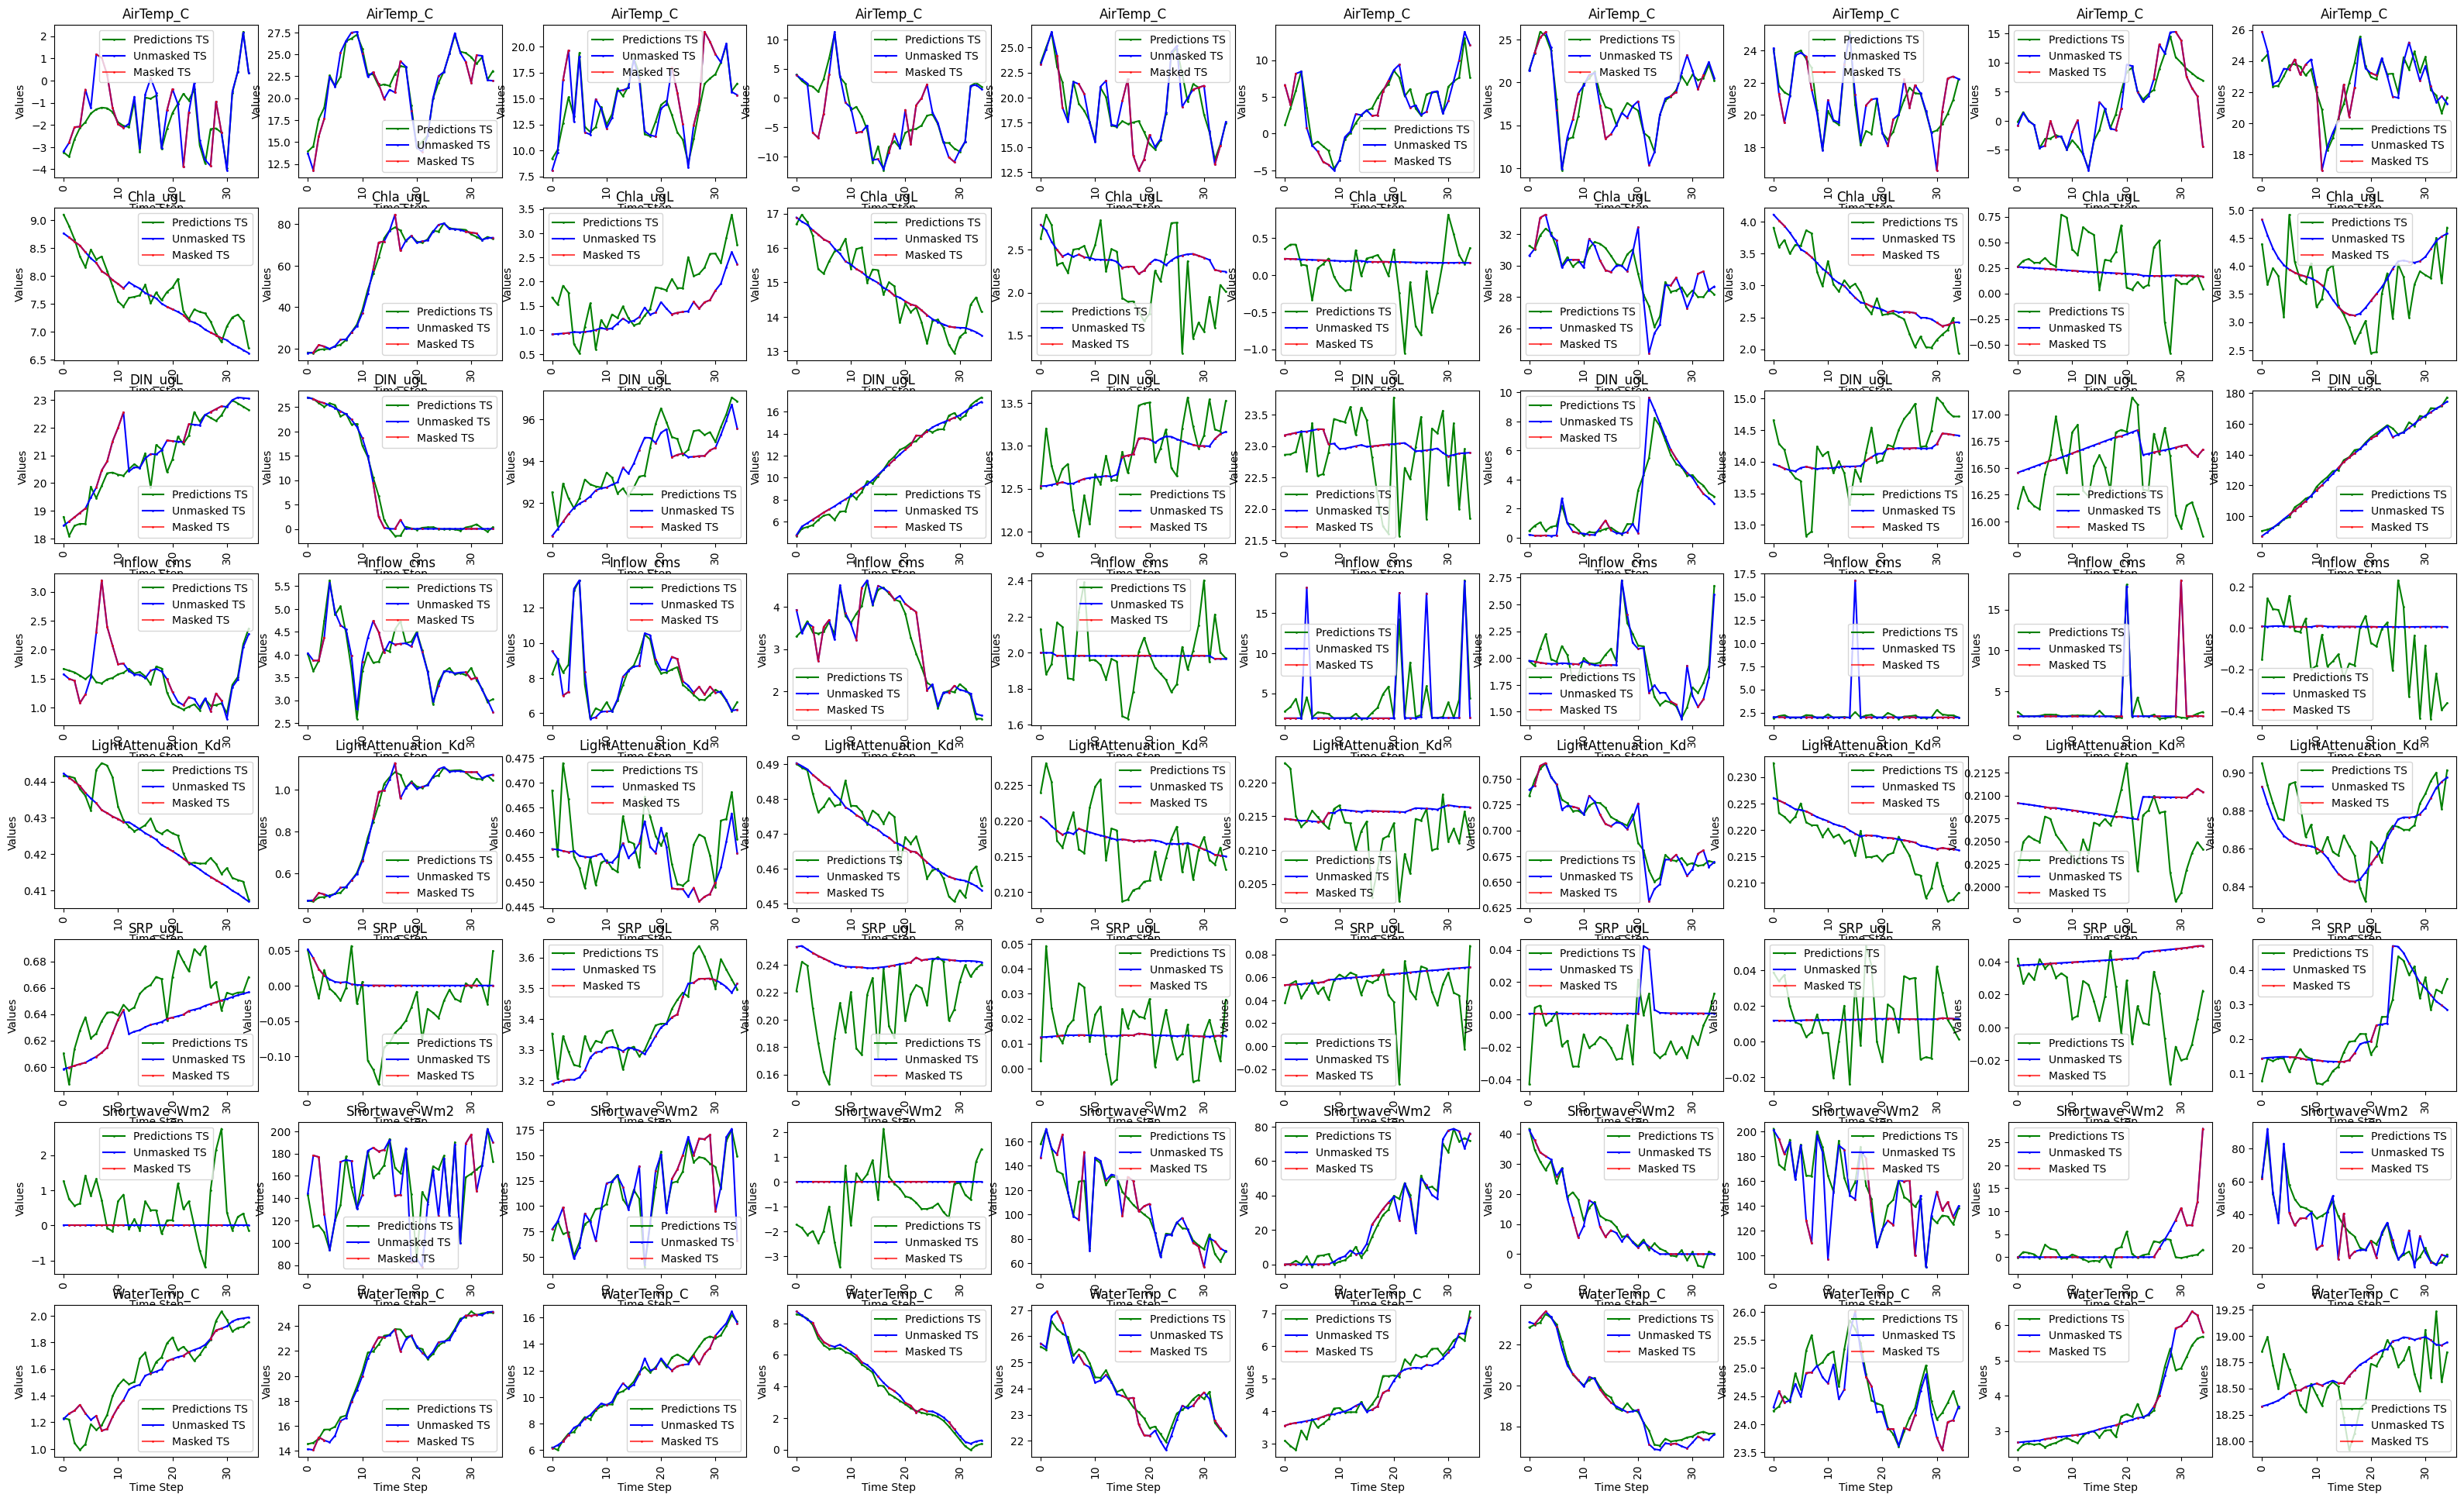

In [24]:
history = model.train_model(train_X, val_X, config)

In [30]:
torch.save(model, './checkpoints/mae_with_masking.pth')

# Zero-shot Forecasting

In [25]:
model.forecast_evaluate(train_X, val_X, config, lookback=14)

Lookback window has been set to 14, forecast window has been set to 21
Masking Mode has been set to continuous_masking


368it [00:01, 201.78it/s]
1481it [00:07, 200.05it/s]


val avg loss = 0.9151632224574037
train avg loss = 0.8229614207866947


/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:483: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


# Finetuning Model for Forecasting

In [23]:
# model = MaskedAutoencoder(utils, **model_args)
model = torch.load('./checkpoints/mae_with_masking.pth', map_location="cpu")
# model.load_state_dict(ckpt)

In [24]:
finetune_args = {
    'batch_size':32,
    'accum_iter':1,
    'min_lr':1e-5,
    'weight_decay':0.05,
    'lr': 5e-4,
    'blr': 1e-4, # not being used right now
    'warmup_epochs':5, #40
    'max_epochs': 40, #600
    'device':device,
    'project_name': wandb_project,
    'run_name': wandb_run,
    'save_code': save_code,
    'eval_freq':1,
    'target_col_ind':target_col_ind,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor,
    "task_name":"finetune",               #extra params for finetune
    "lookback":14,  #extra params for finetune
    "num_samples":10, 
    "num_windows":25,
    "freeze_encoder":True,
}

config = {**model_args, **finetune_args}

In [25]:
history = model.train_model(train_X, val_X, config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Mask Penalize Has been set to True.
Lookback window has been set to 14, forecast window has been set to 21
Masking Mode has been set to continuous_masking
Emcoder Blocks Frozen!


wandb: Currently logged in as: aneog. Use `wandb login --relogin` to force relogin


  0%|                                                                                                                                           | 0/40 [00:00<?, ?it/s]

learning rate in epoch 0 = 0.0001 



0it [00:00, ?it/s]
23it [00:00, 225.21it/s]
46it [00:00, 222.72it/s]
70it [00:00, 227.79it/s]
94it [00:00, 229.64it/s]
118it [00:00, 230.63it/s]
144it [00:00, 239.07it/s]
176it [00:00, 262.56it/s]
208it [00:00, 278.22it/s]
239it [00:00, 285.61it/s]
268it [00:01, 265.13it/s]
295it [00:01, 253.51it/s]
321it [00:01, 246.78it/s]
368it [00:01, 247.11it/s]

0it [00:00, ?it/s]
24it [00:00, 235.38it/s]
48it [00:00, 233.07it/s]
72it [00:00, 232.91it/s]
96it [00:00, 234.50it/s]
120it [00:00, 234.80it/s]
144it [00:00, 234.28it/s]
168it [00:00, 228.74it/s]
191it [00:00, 227.11it/s]
215it [00:00, 228.86it/s]
239it [00:01, 230.44it/s]
263it [00:01, 230.62it/s]
287it [00:01, 231.28it/s]
311it [00:01, 231.91it/s]
335it [00:01, 231.48it/s]
359it [00:01, 232.07it/s]
383it [00:01, 230.08it/s]
407it [00:01, 231.18it/s]
431it [00:01, 231.28it/s]
455it [00:01, 231.76it/s]
479it [00:02, 228.62it/s]
503it [00:02, 230.67it/s]
527it [00:02, 231.90it/s]
551it [00:02, 231.67it/s]
575it [00:02, 230.95it/s]
599it 

val avg loss = 0.16291880641011117
train avg loss = 0.17155615673359587


/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:605: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/home/abhilash22/Eco-KGML/Transformer/lake_foundation_model/masked_pre_training/utils.py:483: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  2%|██                                                                                  | 1/40 [00:58<38:08, 58.68s/it, mse_loss=0.17, train_rmse=8.08, val_rmse=8.03]

learning rate in epoch 1 = 0.0002 



0it [00:00, ?it/s]
25it [00:00, 244.68it/s]
50it [00:00, 240.85it/s]
75it [00:00, 238.51it/s]
99it [00:00, 233.52it/s]
123it [00:00, 234.32it/s]
147it [00:00, 234.10it/s]
171it [00:00, 234.34it/s]
195it [00:00, 234.36it/s]
219it [00:00, 233.44it/s]
243it [00:01, 232.27it/s]
267it [00:01, 232.95it/s]
291it [00:01, 233.33it/s]
315it [00:01, 232.72it/s]
339it [00:01, 232.38it/s]
368it [00:01, 233.36it/s]

0it [00:00, ?it/s]
24it [00:00, 237.84it/s]
48it [00:00, 233.64it/s]
72it [00:00, 234.09it/s]
96it [00:00, 232.09it/s]
120it [00:00, 229.94it/s]
144it [00:00, 231.21it/s]
168it [00:00, 232.70it/s]
192it [00:00, 233.51it/s]
216it [00:00, 232.31it/s]
240it [00:01, 232.09it/s]
264it [00:01, 232.80it/s]
288it [00:01, 230.04it/s]
312it [00:01, 229.76it/s]
336it [00:01, 231.50it/s]
360it [00:01, 231.05it/s]
384it [00:01, 232.71it/s]
408it [00:01, 232.47it/s]
432it [00:01, 232.31it/s]
456it [00:01, 232.06it/s]
480it [00:02, 232.67it/s]
504it [00:02, 233.43it/s]
528it [00:02, 232.40it/s]
552it 

val avg loss = 0.15820818240551845
train avg loss = 0.16852710468243057


  5%|████▏                                                                              | 2/40 [01:57<37:08, 58.64s/it, mse_loss=0.153, train_rmse=7.88, val_rmse=7.76]

learning rate in epoch 2 = 0.00030000000000000003 



0it [00:00, ?it/s]
23it [00:00, 228.87it/s]
46it [00:00, 222.68it/s]
70it [00:00, 228.75it/s]
94it [00:00, 229.82it/s]
117it [00:00, 228.96it/s]
141it [00:00, 231.99it/s]
169it [00:00, 244.38it/s]
194it [00:00, 235.23it/s]
218it [00:00, 234.91it/s]
242it [00:01, 232.52it/s]
266it [00:01, 231.19it/s]
290it [00:01, 231.13it/s]
314it [00:01, 231.89it/s]
338it [00:01, 231.46it/s]
368it [00:01, 231.64it/s]

0it [00:00, ?it/s]
24it [00:00, 234.64it/s]
48it [00:00, 228.47it/s]
71it [00:00, 226.96it/s]
94it [00:00, 225.32it/s]
117it [00:00, 225.57it/s]
141it [00:00, 227.85it/s]
164it [00:00, 225.66it/s]
187it [00:00, 225.35it/s]
210it [00:00, 226.03it/s]
234it [00:01, 227.54it/s]
257it [00:01, 225.97it/s]
281it [00:01, 228.08it/s]
305it [00:01, 229.76it/s]
328it [00:01, 222.03it/s]
352it [00:01, 224.79it/s]
376it [00:01, 227.77it/s]
400it [00:01, 230.18it/s]
424it [00:01, 231.12it/s]
448it [00:01, 230.67it/s]
472it [00:02, 231.58it/s]
496it [00:02, 231.48it/s]
520it [00:02, 231.18it/s]
544it 

val avg loss = 0.16829079909898018
train avg loss = 0.17764354892110276


  8%|██████▏                                                                            | 3/40 [02:55<36:03, 58.48s/it, mse_loss=0.148, train_rmse=7.79, val_rmse=7.78]

learning rate in epoch 3 = 0.0004 



0it [00:00, ?it/s]
24it [00:00, 233.55it/s]
48it [00:00, 233.05it/s]
72it [00:00, 232.37it/s]
96it [00:00, 229.39it/s]
119it [00:00, 229.46it/s]
142it [00:00, 224.95it/s]
165it [00:00, 226.42it/s]
188it [00:00, 224.73it/s]
212it [00:00, 227.15it/s]
235it [00:01, 227.54it/s]
258it [00:01, 224.48it/s]
281it [00:01, 222.23it/s]
304it [00:01, 220.72it/s]
327it [00:01, 222.83it/s]
368it [00:01, 224.70it/s]

0it [00:00, ?it/s]
23it [00:00, 228.59it/s]
47it [00:00, 231.51it/s]
71it [00:00, 230.05it/s]
95it [00:00, 230.28it/s]
119it [00:00, 230.63it/s]
143it [00:00, 231.15it/s]
167it [00:00, 233.24it/s]
191it [00:00, 234.25it/s]
215it [00:00, 229.73it/s]
239it [00:01, 229.79it/s]
263it [00:01, 230.22it/s]
287it [00:01, 227.76it/s]
311it [00:01, 228.73it/s]
334it [00:01, 228.26it/s]
358it [00:01, 229.21it/s]
381it [00:01, 228.97it/s]
404it [00:01, 228.83it/s]
427it [00:01, 228.57it/s]
450it [00:01, 225.25it/s]
473it [00:02, 226.01it/s]
497it [00:02, 227.54it/s]
521it [00:02, 228.78it/s]
545it 

val avg loss = 0.17872169645219718
train avg loss = 0.18556171266901622


 10%|████████▎                                                                          | 4/40 [03:54<35:07, 58.54s/it, mse_loss=0.144, train_rmse=7.71, val_rmse=7.68]

learning rate in epoch 4 = 0.0005 



0it [00:00, ?it/s]
22it [00:00, 214.18it/s]
44it [00:00, 205.68it/s]
75it [00:00, 250.30it/s]
106it [00:00, 270.59it/s]
135it [00:00, 276.68it/s]
166it [00:00, 286.90it/s]
197it [00:00, 291.59it/s]
227it [00:00, 290.59it/s]
257it [00:00, 291.02it/s]
287it [00:01, 291.16it/s]
318it [00:01, 294.26it/s]
368it [00:01, 282.62it/s]

0it [00:00, ?it/s]
31it [00:00, 309.34it/s]
62it [00:00, 301.10it/s]
93it [00:00, 257.22it/s]
120it [00:00, 243.86it/s]
145it [00:00, 237.75it/s]
169it [00:00, 232.43it/s]
193it [00:00, 233.43it/s]
217it [00:00, 232.31it/s]
241it [00:00, 232.28it/s]
265it [00:01, 232.49it/s]
289it [00:01, 233.49it/s]
313it [00:01, 233.29it/s]
337it [00:01, 225.61it/s]
360it [00:01, 226.24it/s]
383it [00:01, 222.01it/s]
406it [00:01, 221.51it/s]
430it [00:01, 224.34it/s]
453it [00:01, 224.11it/s]
476it [00:02, 224.39it/s]
499it [00:02, 225.80it/s]
522it [00:02, 225.76it/s]
545it [00:02, 224.60it/s]
569it [00:02, 227.73it/s]
593it [00:02, 228.70it/s]
616it [00:02, 228.53it/s]
639i

val avg loss = 0.19132735003190843
train avg loss = 0.19600042258310688


 12%|██████████▍                                                                        | 5/40 [04:52<34:04, 58.42s/it, mse_loss=0.141, train_rmse=7.71, val_rmse=7.77]

learning rate in epoch 5 = 0.0004990137020288336 



0it [00:00, ?it/s]
22it [00:00, 214.08it/s]
46it [00:00, 226.15it/s]
69it [00:00, 227.53it/s]
93it [00:00, 231.72it/s]
117it [00:00, 232.27it/s]
141it [00:00, 231.81it/s]
165it [00:00, 226.62it/s]
188it [00:00, 227.54it/s]
211it [00:00, 220.61it/s]
234it [00:01, 223.06it/s]
257it [00:01, 221.46it/s]
280it [00:01, 217.81it/s]
303it [00:01, 221.22it/s]
326it [00:01, 215.54it/s]
368it [00:01, 222.54it/s]

0it [00:00, ?it/s]
23it [00:00, 220.50it/s]
46it [00:00, 220.67it/s]
69it [00:00, 218.79it/s]
92it [00:00, 221.16it/s]
115it [00:00, 220.97it/s]
138it [00:00, 222.71it/s]
161it [00:00, 216.39it/s]
184it [00:00, 218.21it/s]
206it [00:00, 215.90it/s]
228it [00:01, 211.36it/s]
250it [00:01, 212.12it/s]
274it [00:01, 218.78it/s]
296it [00:01, 207.37it/s]
319it [00:01, 213.53it/s]
343it [00:01, 219.12it/s]
366it [00:01, 216.73it/s]
389it [00:01, 218.99it/s]
412it [00:01, 220.67it/s]
435it [00:02, 209.51it/s]
458it [00:02, 214.79it/s]
481it [00:02, 216.98it/s]
504it [00:02, 219.34it/s]
527it 

val avg loss = 0.20049089204479495
train avg loss = 0.2070129588824885


 15%|████████████▍                                                                      | 6/40 [05:50<33:02, 58.31s/it, mse_loss=0.136, train_rmse=7.62, val_rmse=7.68]

learning rate in epoch 6 = 0.0004960627492066643 



0it [00:00, ?it/s]
24it [00:00, 236.24it/s]
48it [00:00, 235.86it/s]
72it [00:00, 234.02it/s]
96it [00:00, 234.88it/s]
120it [00:00, 230.75it/s]
144it [00:00, 233.56it/s]
168it [00:00, 233.88it/s]
192it [00:00, 231.48it/s]
216it [00:00, 232.50it/s]
240it [00:01, 234.19it/s]
264it [00:01, 235.70it/s]
289it [00:01, 237.33it/s]
313it [00:01, 235.39it/s]
337it [00:01, 236.10it/s]
368it [00:01, 233.52it/s]

0it [00:00, ?it/s]
25it [00:00, 240.32it/s]
50it [00:00, 235.85it/s]
74it [00:00, 231.83it/s]
98it [00:00, 232.52it/s]
122it [00:00, 230.12it/s]
146it [00:00, 229.04it/s]
170it [00:00, 230.48it/s]
194it [00:00, 231.53it/s]
218it [00:00, 232.02it/s]
242it [00:01, 232.31it/s]
266it [00:01, 233.02it/s]
290it [00:01, 230.71it/s]
314it [00:01, 228.71it/s]
338it [00:01, 229.91it/s]
361it [00:01, 229.92it/s]
384it [00:01, 227.55it/s]
408it [00:01, 228.82it/s]
431it [00:01, 228.62it/s]
454it [00:01, 227.43it/s]
477it [00:02, 227.73it/s]
501it [00:02, 228.79it/s]
525it [00:02, 229.68it/s]
548it 

val avg loss = 0.19611023499063499
train avg loss = 0.2016308412640019


 18%|██████████████▌                                                                    | 7/40 [06:49<32:06, 58.38s/it, mse_loss=0.133, train_rmse=7.53, val_rmse=7.54]

learning rate in epoch 7 = 0.000491170900870484 



0it [00:00, ?it/s]
25it [00:00, 243.19it/s]
50it [00:00, 239.43it/s]
74it [00:00, 237.16it/s]
98it [00:00, 235.60it/s]
122it [00:00, 236.35it/s]
146it [00:00, 237.18it/s]
170it [00:00, 234.72it/s]
194it [00:00, 235.60it/s]
218it [00:00, 236.45it/s]
242it [00:01, 236.80it/s]
266it [00:01, 236.37it/s]
290it [00:01, 230.04it/s]
314it [00:01, 232.21it/s]
338it [00:01, 233.54it/s]
368it [00:01, 234.30it/s]

0it [00:00, ?it/s]
24it [00:00, 235.25it/s]
48it [00:00, 231.24it/s]
72it [00:00, 232.01it/s]
96it [00:00, 233.96it/s]
120it [00:00, 234.58it/s]
144it [00:00, 233.65it/s]
168it [00:00, 233.13it/s]
192it [00:00, 227.65it/s]
216it [00:00, 228.59it/s]
239it [00:01, 228.64it/s]
263it [00:01, 230.52it/s]
287it [00:01, 225.49it/s]
311it [00:01, 228.26it/s]
335it [00:01, 229.54it/s]
359it [00:01, 232.49it/s]
383it [00:01, 233.42it/s]
407it [00:01, 233.73it/s]
431it [00:01, 232.99it/s]
455it [00:01, 231.26it/s]
479it [00:02, 230.33it/s]
503it [00:02, 231.02it/s]
527it [00:02, 232.16it/s]
551it 

val avg loss = 0.20314014332530939
train avg loss = 0.20922163403784802


 20%|█████████████████                                                                    | 8/40 [07:44<30:43, 57.61s/it, mse_loss=0.13, train_rmse=7.55, val_rmse=7.6]

learning rate in epoch 8 = 0.0004843775433067356 



0it [00:00, ?it/s]
23it [00:00, 228.21it/s]
46it [00:00, 227.57it/s]
69it [00:00, 228.00it/s]
93it [00:00, 229.81it/s]
116it [00:00, 229.27it/s]
140it [00:00, 230.44it/s]
164it [00:00, 231.00it/s]
188it [00:00, 233.10it/s]
212it [00:00, 234.74it/s]
236it [00:01, 233.96it/s]
260it [00:01, 229.08it/s]
284it [00:01, 230.54it/s]
308it [00:01, 229.11it/s]
331it [00:01, 225.06it/s]
368it [00:01, 228.68it/s]

0it [00:00, ?it/s]
24it [00:00, 233.24it/s]
48it [00:00, 235.25it/s]
72it [00:00, 232.53it/s]
96it [00:00, 234.50it/s]
120it [00:00, 233.16it/s]
144it [00:00, 231.60it/s]
168it [00:00, 232.66it/s]
192it [00:00, 234.29it/s]
216it [00:00, 234.90it/s]
240it [00:01, 235.10it/s]
264it [00:01, 234.88it/s]
288it [00:01, 234.68it/s]
312it [00:01, 234.26it/s]
336it [00:01, 233.50it/s]
360it [00:01, 231.74it/s]
384it [00:01, 231.39it/s]
408it [00:01, 231.80it/s]
432it [00:01, 232.18it/s]
456it [00:01, 233.27it/s]
480it [00:02, 232.82it/s]
504it [00:02, 232.89it/s]
528it [00:02, 232.40it/s]
552it 

val avg loss = 0.22237082939271047
train avg loss = 0.22402659357650548


 22%|██████████████████▋                                                                | 9/40 [08:44<30:07, 58.30s/it, mse_loss=0.128, train_rmse=7.49, val_rmse=7.53]

learning rate in epoch 9 = 0.00047573737263609267 



0it [00:00, ?it/s]
24it [00:00, 232.46it/s]
48it [00:00, 232.20it/s]
72it [00:00, 231.33it/s]
96it [00:00, 230.59it/s]
120it [00:00, 231.68it/s]
144it [00:00, 227.79it/s]
168it [00:00, 229.21it/s]
191it [00:00, 229.06it/s]
214it [00:00, 229.01it/s]
238it [00:01, 230.51it/s]
262it [00:01, 230.05it/s]
286it [00:01, 230.71it/s]
310it [00:01, 229.81it/s]
334it [00:01, 230.38it/s]
368it [00:01, 229.48it/s]

0it [00:00, ?it/s]
24it [00:00, 234.21it/s]
48it [00:00, 231.69it/s]
72it [00:00, 230.92it/s]
96it [00:00, 229.95it/s]
120it [00:00, 230.34it/s]
144it [00:00, 229.55it/s]
168it [00:00, 229.89it/s]
192it [00:00, 231.26it/s]
216it [00:00, 230.65it/s]
240it [00:01, 229.15it/s]
264it [00:01, 230.50it/s]
288it [00:01, 224.98it/s]
311it [00:01, 224.83it/s]
334it [00:01, 224.10it/s]
358it [00:01, 226.11it/s]
381it [00:01, 223.82it/s]
405it [00:01, 226.10it/s]
429it [00:01, 227.54it/s]
452it [00:01, 224.21it/s]
476it [00:02, 226.57it/s]
500it [00:02, 228.58it/s]
523it [00:02, 221.45it/s]
546it 

val avg loss = 0.22671388535071973
train avg loss = 0.22795958417309933


 25%|████████████████████▌                                                             | 10/40 [09:42<29:02, 58.09s/it, mse_loss=0.126, train_rmse=7.44, val_rmse=7.53]

learning rate in epoch 10 = 0.00046531995443245723 



0it [00:00, ?it/s]
23it [00:00, 229.96it/s]
46it [00:00, 225.16it/s]
69it [00:00, 226.68it/s]
92it [00:00, 227.91it/s]
116it [00:00, 228.95it/s]
139it [00:00, 228.46it/s]
162it [00:00, 228.64it/s]
185it [00:00, 228.88it/s]
209it [00:00, 230.06it/s]
233it [00:01, 230.92it/s]
257it [00:01, 230.74it/s]
281it [00:01, 229.70it/s]
304it [00:01, 224.70it/s]
327it [00:01, 217.06it/s]
368it [00:01, 225.46it/s]

0it [00:00, ?it/s]
22it [00:00, 213.41it/s]
46it [00:00, 224.49it/s]
69it [00:00, 222.28it/s]
93it [00:00, 226.96it/s]
117it [00:00, 228.82it/s]
141it [00:00, 230.89it/s]
165it [00:00, 230.59it/s]
189it [00:00, 231.81it/s]
213it [00:00, 232.08it/s]
237it [00:01, 229.73it/s]
261it [00:01, 230.58it/s]
285it [00:01, 230.75it/s]
309it [00:01, 230.96it/s]
333it [00:01, 232.01it/s]
357it [00:01, 231.79it/s]
381it [00:01, 231.86it/s]
405it [00:01, 230.09it/s]
429it [00:01, 230.93it/s]
453it [00:01, 230.75it/s]
477it [00:02, 226.82it/s]
500it [00:02, 226.51it/s]
523it [00:02, 225.81it/s]
546it 

val avg loss = 0.23555721231209842
train avg loss = 0.23554184845951182


 28%|██████████████████████▌                                                           | 11/40 [10:43<28:33, 59.08s/it, mse_loss=0.124, train_rmse=7.42, val_rmse=7.54]

learning rate in epoch 11 = 0.00045320916362186214 



0it [00:00, ?it/s]
23it [00:00, 229.74it/s]
47it [00:00, 232.53it/s]
71it [00:00, 231.99it/s]
95it [00:00, 233.34it/s]
119it [00:00, 230.40it/s]
143it [00:00, 226.72it/s]
166it [00:00, 223.17it/s]
189it [00:00, 223.92it/s]
212it [00:00, 218.51it/s]
236it [00:01, 222.40it/s]
259it [00:01, 224.37it/s]
282it [00:01, 225.41it/s]
306it [00:01, 227.60it/s]
329it [00:01, 228.19it/s]
368it [00:01, 226.95it/s]

0it [00:00, ?it/s]
23it [00:00, 226.92it/s]
46it [00:00, 213.94it/s]
70it [00:00, 221.59it/s]
93it [00:00, 220.90it/s]
116it [00:00, 221.46it/s]
140it [00:00, 226.88it/s]
163it [00:00, 223.65it/s]
187it [00:00, 227.00it/s]
211it [00:00, 228.40it/s]
234it [00:01, 222.31it/s]
258it [00:01, 225.74it/s]
281it [00:01, 224.12it/s]
304it [00:01, 224.26it/s]
328it [00:01, 227.21it/s]
351it [00:01, 220.88it/s]
375it [00:01, 225.53it/s]
399it [00:01, 228.44it/s]
422it [00:01, 223.92it/s]
445it [00:01, 225.22it/s]
468it [00:02, 219.11it/s]
490it [00:02, 218.57it/s]
512it [00:02, 217.75it/s]
535it 

val avg loss = 0.2656734946548291
train avg loss = 0.2625928869411842


 30%|████████████████████████▉                                                          | 12/40 [11:41<27:24, 58.73s/it, mse_loss=0.122, train_rmse=7.4, val_rmse=7.53]

learning rate in epoch 12 = 0.00043950250917088474 



0it [00:00, ?it/s]
24it [00:00, 231.06it/s]
48it [00:00, 231.73it/s]
72it [00:00, 233.19it/s]
96it [00:00, 234.18it/s]
120it [00:00, 234.09it/s]
144it [00:00, 232.82it/s]
168it [00:00, 232.41it/s]
192it [00:00, 233.03it/s]
216it [00:00, 232.67it/s]
240it [00:01, 232.88it/s]
264it [00:01, 233.75it/s]
288it [00:01, 232.63it/s]
312it [00:01, 232.26it/s]
336it [00:01, 231.29it/s]
368it [00:01, 231.78it/s]

0it [00:00, ?it/s]
23it [00:00, 227.15it/s]
47it [00:00, 229.30it/s]
71it [00:00, 230.22it/s]
95it [00:00, 230.74it/s]
119it [00:00, 231.47it/s]
143it [00:00, 230.65it/s]
167it [00:00, 230.38it/s]
191it [00:00, 230.27it/s]
215it [00:00, 230.73it/s]
239it [00:01, 230.97it/s]
263it [00:01, 228.80it/s]
287it [00:01, 229.31it/s]
310it [00:01, 228.69it/s]
334it [00:01, 229.27it/s]
357it [00:01, 229.26it/s]
380it [00:01, 229.31it/s]
404it [00:01, 229.60it/s]
427it [00:01, 229.29it/s]
450it [00:01, 229.36it/s]
473it [00:02, 228.89it/s]
496it [00:02, 229.04it/s]
519it [00:02, 228.26it/s]
542it 

val avg loss = 0.270628172053915
train avg loss = 0.26403825237069234


 32%|██████████████████████████▉                                                        | 13/40 [12:39<26:14, 58.30s/it, mse_loss=0.12, train_rmse=7.42, val_rmse=7.51]

learning rate in epoch 13 = 0.00042431034900178186 



0it [00:00, ?it/s]
23it [00:00, 229.07it/s]
47it [00:00, 230.32it/s]
71it [00:00, 231.73it/s]
95it [00:00, 231.64it/s]
119it [00:00, 232.36it/s]
143it [00:00, 231.56it/s]
167it [00:00, 232.03it/s]
191it [00:00, 231.75it/s]
215it [00:00, 232.13it/s]
239it [00:01, 232.47it/s]
263it [00:01, 229.84it/s]
286it [00:01, 229.13it/s]
310it [00:01, 230.20it/s]
334it [00:01, 231.10it/s]
368it [00:01, 230.82it/s]

0it [00:00, ?it/s]
24it [00:00, 235.10it/s]
48it [00:00, 232.37it/s]
72it [00:00, 232.40it/s]
96it [00:00, 232.73it/s]
120it [00:00, 231.85it/s]
144it [00:00, 229.36it/s]
167it [00:00, 228.61it/s]
190it [00:00, 227.45it/s]
214it [00:00, 229.95it/s]
237it [00:01, 229.79it/s]
261it [00:01, 231.74it/s]
285it [00:01, 232.00it/s]
309it [00:01, 231.50it/s]
333it [00:01, 232.26it/s]
357it [00:01, 230.99it/s]
381it [00:01, 230.31it/s]
405it [00:01, 230.37it/s]
429it [00:01, 231.26it/s]
453it [00:01, 230.76it/s]
477it [00:02, 232.51it/s]
501it [00:02, 232.76it/s]
525it [00:02, 232.62it/s]
549it 

val avg loss = 0.28063016909215116
train avg loss = 0.2749734939372193


 35%|████████████████████████████▋                                                     | 14/40 [13:39<25:36, 59.09s/it, mse_loss=0.118, train_rmse=7.35, val_rmse=7.52]

learning rate in epoch 14 = 0.0004077550014553897 



0it [00:00, ?it/s]
28it [00:00, 273.29it/s]
60it [00:00, 296.28it/s]
91it [00:00, 301.08it/s]
122it [00:00, 301.69it/s]
153it [00:00, 304.32it/s]
184it [00:00, 304.89it/s]
215it [00:00, 304.90it/s]
246it [00:00, 293.68it/s]
276it [00:00, 293.66it/s]
306it [00:01, 294.67it/s]
336it [00:01, 294.83it/s]
368it [00:01, 296.21it/s]

0it [00:00, ?it/s]
30it [00:00, 297.16it/s]
60it [00:00, 298.14it/s]
90it [00:00, 297.00it/s]
120it [00:00, 273.15it/s]
148it [00:00, 254.63it/s]
174it [00:00, 246.25it/s]
199it [00:00, 237.66it/s]
223it [00:00, 236.19it/s]
247it [00:00, 234.81it/s]
271it [00:01, 234.10it/s]
295it [00:01, 232.63it/s]
319it [00:01, 231.64it/s]
343it [00:01, 231.97it/s]
367it [00:01, 231.99it/s]
391it [00:01, 230.84it/s]
415it [00:01, 231.25it/s]
439it [00:01, 229.16it/s]
463it [00:01, 229.62it/s]
487it [00:02, 230.29it/s]
511it [00:02, 231.54it/s]
535it [00:02, 232.33it/s]
559it [00:02, 232.08it/s]
583it [00:02, 231.77it/s]
607it [00:02, 230.58it/s]
631it [00:02, 231.59it/s]
655i

val avg loss = 0.3396864247953762
train avg loss = 0.3219158287807182


 38%|██████████████████████████████▊                                                   | 15/40 [14:36<24:15, 58.21s/it, mse_loss=0.116, train_rmse=7.34, val_rmse=7.48]

learning rate in epoch 15 = 0.00038996976045576514 



0it [00:00, ?it/s]
24it [00:00, 235.45it/s]
48it [00:00, 232.39it/s]
72it [00:00, 231.64it/s]
96it [00:00, 230.86it/s]
120it [00:00, 231.39it/s]
144it [00:00, 232.25it/s]
168it [00:00, 232.11it/s]
192it [00:00, 223.82it/s]
215it [00:00, 224.21it/s]
239it [00:01, 227.01it/s]
263it [00:01, 228.62it/s]
286it [00:01, 217.48it/s]
309it [00:01, 220.09it/s]
333it [00:01, 223.44it/s]
368it [00:01, 226.24it/s]

0it [00:00, ?it/s]
24it [00:00, 235.85it/s]
48it [00:00, 228.70it/s]
71it [00:00, 216.44it/s]
95it [00:00, 223.20it/s]
119it [00:00, 224.21it/s]
142it [00:00, 224.76it/s]
166it [00:00, 227.27it/s]
190it [00:00, 230.63it/s]
214it [00:00, 231.56it/s]
238it [00:01, 232.03it/s]
262it [00:01, 233.36it/s]
286it [00:01, 231.57it/s]
310it [00:01, 228.00it/s]
334it [00:01, 229.34it/s]
358it [00:01, 230.44it/s]
382it [00:01, 231.08it/s]
406it [00:01, 231.33it/s]
430it [00:01, 229.99it/s]
454it [00:01, 230.19it/s]
478it [00:02, 230.41it/s]
502it [00:02, 231.00it/s]
526it [00:02, 230.82it/s]
550it 

val avg loss = 0.35332623978509853
train avg loss = 0.33421164102082634


 40%|████████████████████████████████▊                                                 | 16/40 [15:33<23:10, 57.94s/it, mse_loss=0.114, train_rmse=7.33, val_rmse=7.47]

learning rate in epoch 16 = 0.00037109782230588465 



0it [00:00, ?it/s]
22it [00:00, 219.50it/s]
46it [00:00, 226.49it/s]
70it [00:00, 229.81it/s]
94it [00:00, 230.61it/s]
118it [00:00, 231.44it/s]
142it [00:00, 226.91it/s]
166it [00:00, 228.29it/s]
190it [00:00, 229.50it/s]
214it [00:00, 230.54it/s]
238it [00:01, 231.94it/s]
262it [00:01, 232.55it/s]
286it [00:01, 226.94it/s]
310it [00:01, 228.91it/s]
333it [00:01, 227.36it/s]
368it [00:01, 228.84it/s]

0it [00:00, ?it/s]
24it [00:00, 238.20it/s]
48it [00:00, 234.12it/s]
72it [00:00, 222.28it/s]
95it [00:00, 224.68it/s]
118it [00:00, 226.41it/s]
142it [00:00, 228.36it/s]
166it [00:00, 229.34it/s]
189it [00:00, 229.50it/s]
212it [00:00, 226.90it/s]
235it [00:01, 221.41it/s]
259it [00:01, 225.65it/s]
283it [00:01, 226.88it/s]
307it [00:01, 228.19it/s]
331it [00:01, 230.21it/s]
355it [00:01, 230.50it/s]
379it [00:01, 230.79it/s]
403it [00:01, 230.11it/s]
427it [00:01, 229.71it/s]
451it [00:01, 230.89it/s]
475it [00:02, 231.54it/s]
499it [00:02, 229.05it/s]
523it [00:02, 229.95it/s]
547it 

val avg loss = 0.3618337557165195
train avg loss = 0.32970123247549715


 42%|███████████████████████████████████▎                                               | 17/40 [16:35<22:39, 59.10s/it, mse_loss=0.113, train_rmse=7.3, val_rmse=7.46]

learning rate in epoch 17 = 0.00035129113275521133 



0it [00:00, ?it/s]
23it [00:00, 227.45it/s]
46it [00:00, 227.95it/s]
69it [00:00, 228.32it/s]
93it [00:00, 229.46it/s]
117it [00:00, 230.33it/s]
141it [00:00, 228.98it/s]
165it [00:00, 229.59it/s]
189it [00:00, 230.16it/s]
213it [00:00, 230.83it/s]
237it [00:01, 231.22it/s]
261it [00:01, 231.25it/s]
285it [00:01, 232.31it/s]
309it [00:01, 229.81it/s]
332it [00:01, 228.29it/s]
368it [00:01, 227.92it/s]

0it [00:00, ?it/s]
23it [00:00, 228.65it/s]
46it [00:00, 218.40it/s]
69it [00:00, 223.14it/s]
92it [00:00, 222.08it/s]
116it [00:00, 225.29it/s]
139it [00:00, 225.99it/s]
162it [00:00, 226.89it/s]
185it [00:00, 226.15it/s]
209it [00:00, 228.10it/s]
232it [00:01, 227.71it/s]
255it [00:01, 227.32it/s]
279it [00:01, 229.01it/s]
302it [00:01, 228.17it/s]
325it [00:01, 228.24it/s]
349it [00:01, 229.69it/s]
373it [00:01, 231.12it/s]
397it [00:01, 230.96it/s]
421it [00:01, 230.19it/s]
445it [00:01, 228.91it/s]
468it [00:02, 228.65it/s]
492it [00:02, 229.48it/s]
515it [00:02, 229.29it/s]
539it 

val avg loss = 0.3864549052516889
train avg loss = 0.3527175650242049


 45%|█████████████████████████████████████▎                                             | 18/40 [17:32<21:29, 58.62s/it, mse_loss=0.111, train_rmse=7.3, val_rmse=7.42]

learning rate in epoch 18 = 0.00033070916362186215 



0it [00:00, ?it/s]
24it [00:00, 232.79it/s]
48it [00:00, 232.03it/s]
72it [00:00, 227.51it/s]
96it [00:00, 228.77it/s]
119it [00:00, 228.48it/s]
143it [00:00, 229.06it/s]
166it [00:00, 229.19it/s]
190it [00:00, 229.58it/s]
214it [00:00, 231.21it/s]
238it [00:01, 229.79it/s]
261it [00:01, 229.61it/s]
284it [00:01, 228.93it/s]
307it [00:01, 226.43it/s]
330it [00:01, 226.48it/s]
368it [00:01, 228.76it/s]

0it [00:00, ?it/s]
24it [00:00, 232.90it/s]
48it [00:00, 229.89it/s]
71it [00:00, 228.82it/s]
94it [00:00, 227.14it/s]
117it [00:00, 227.61it/s]
140it [00:00, 227.61it/s]
163it [00:00, 228.31it/s]
186it [00:00, 227.26it/s]
210it [00:00, 229.16it/s]
233it [00:01, 224.61it/s]
256it [00:01, 222.08it/s]
279it [00:01, 223.93it/s]
303it [00:01, 226.72it/s]
327it [00:01, 228.67it/s]
350it [00:01, 229.01it/s]
373it [00:01, 228.95it/s]
396it [00:01, 229.23it/s]
420it [00:01, 229.96it/s]
443it [00:01, 228.69it/s]
466it [00:02, 227.56it/s]
489it [00:02, 227.59it/s]
513it [00:02, 229.52it/s]
537it 

val avg loss = 0.40765121277502697
train avg loss = 0.3715554893716093


 48%|███████████████████████████████████████▉                                            | 19/40 [18:29<20:22, 58.22s/it, mse_loss=0.11, train_rmse=7.29, val_rmse=7.4]

learning rate in epoch 19 = 0.000309517628819297 



0it [00:00, ?it/s]
24it [00:00, 233.81it/s]
48it [00:00, 212.65it/s]
72it [00:00, 223.12it/s]
95it [00:00, 222.47it/s]
119it [00:00, 225.85it/s]
143it [00:00, 227.78it/s]
166it [00:00, 224.40it/s]
190it [00:00, 227.27it/s]
213it [00:00, 227.23it/s]
236it [00:01, 226.17it/s]
259it [00:01, 221.55it/s]
283it [00:01, 224.49it/s]
307it [00:01, 227.58it/s]
331it [00:01, 228.33it/s]
368it [00:01, 225.93it/s]

0it [00:00, ?it/s]
24it [00:00, 236.41it/s]
48it [00:00, 230.85it/s]
72it [00:00, 230.99it/s]
96it [00:00, 229.82it/s]
119it [00:00, 229.44it/s]
142it [00:00, 224.65it/s]
166it [00:00, 229.01it/s]
189it [00:00, 227.18it/s]
213it [00:00, 228.64it/s]
236it [00:01, 228.44it/s]
260it [00:01, 230.20it/s]
284it [00:01, 224.82it/s]
307it [00:01, 224.43it/s]
330it [00:01, 225.80it/s]
353it [00:01, 225.30it/s]
377it [00:01, 226.88it/s]
400it [00:01, 225.99it/s]
423it [00:01, 224.93it/s]
446it [00:01, 226.06it/s]
469it [00:02, 225.03it/s]
492it [00:02, 222.89it/s]
515it [00:02, 223.18it/s]
539it 

val avg loss = 0.43445373488509137
train avg loss = 0.3807112489305663


 50%|█████████████████████████████████████████▌                                         | 20/40 [19:27<19:19, 57.99s/it, mse_loss=0.108, train_rmse=7.25, val_rmse=7.4]

learning rate in epoch 20 = 0.0002878871501253256 



0it [00:00, ?it/s]
24it [00:00, 231.98it/s]
48it [00:00, 235.47it/s]
72it [00:00, 235.25it/s]
96it [00:00, 235.14it/s]
120it [00:00, 228.69it/s]
143it [00:00, 227.41it/s]
166it [00:00, 227.50it/s]
190it [00:00, 229.21it/s]
214it [00:00, 231.26it/s]
238it [00:01, 232.46it/s]
262it [00:01, 234.37it/s]
286it [00:01, 235.18it/s]
310it [00:01, 233.63it/s]
334it [00:01, 233.55it/s]
368it [00:01, 232.26it/s]

0it [00:00, ?it/s]
24it [00:00, 239.29it/s]
48it [00:00, 233.64it/s]
72it [00:00, 232.21it/s]
96it [00:00, 232.67it/s]
120it [00:00, 234.50it/s]
144it [00:00, 230.95it/s]
168it [00:00, 232.80it/s]
192it [00:00, 232.13it/s]
216it [00:00, 232.60it/s]
240it [00:01, 232.72it/s]
264it [00:01, 231.02it/s]
288it [00:01, 227.05it/s]
311it [00:01, 227.49it/s]
335it [00:01, 229.95it/s]
359it [00:01, 228.91it/s]
383it [00:01, 230.19it/s]
407it [00:01, 231.91it/s]
431it [00:01, 233.00it/s]
455it [00:01, 232.96it/s]
479it [00:02, 231.98it/s]
503it [00:02, 233.04it/s]
527it [00:02, 232.22it/s]
551it 

val avg loss = 0.4588372712428479
train avg loss = 0.4041612465726935


 52%|███████████████████████████████████████████▌                                       | 21/40 [20:30<18:53, 59.66s/it, mse_loss=0.107, train_rmse=7.25, val_rmse=7.4]

learning rate in epoch 21 = 0.0002659918834358762 



0it [00:00, ?it/s]
24it [00:00, 238.63it/s]
48it [00:00, 236.73it/s]
72it [00:00, 233.10it/s]
96it [00:00, 233.33it/s]
120it [00:00, 231.97it/s]
144it [00:00, 231.71it/s]
168it [00:00, 231.04it/s]
192it [00:00, 230.53it/s]
216it [00:00, 229.64it/s]
239it [00:01, 229.36it/s]
262it [00:01, 229.54it/s]
285it [00:01, 229.54it/s]
309it [00:01, 230.35it/s]
333it [00:01, 230.34it/s]
368it [00:01, 230.28it/s]

0it [00:00, ?it/s]
23it [00:00, 227.60it/s]
47it [00:00, 229.88it/s]
71it [00:00, 233.16it/s]
95it [00:00, 233.65it/s]
119it [00:00, 233.67it/s]
143it [00:00, 233.15it/s]
167it [00:00, 233.56it/s]
191it [00:00, 234.34it/s]
215it [00:00, 235.12it/s]
239it [00:01, 234.11it/s]
263it [00:01, 234.82it/s]
287it [00:01, 234.77it/s]
311it [00:01, 235.53it/s]
335it [00:01, 233.27it/s]
359it [00:01, 233.86it/s]
383it [00:01, 233.82it/s]
407it [00:01, 233.37it/s]
431it [00:01, 232.33it/s]
455it [00:01, 232.21it/s]
479it [00:02, 231.88it/s]
503it [00:02, 231.64it/s]
527it [00:02, 230.52it/s]
551it 

val avg loss = 0.4880830605676317
train avg loss = 0.428605427212163


 55%|█████████████████████████████████████████████                                     | 22/40 [21:28<17:39, 58.87s/it, mse_loss=0.106, train_rmse=7.21, val_rmse=7.35]

learning rate in epoch 22 = 0.00024400811656412387 



0it [00:00, ?it/s]
24it [00:00, 234.95it/s]
48it [00:00, 231.82it/s]
72it [00:00, 228.82it/s]
96it [00:00, 230.15it/s]
120it [00:00, 230.91it/s]
144it [00:00, 230.85it/s]
168it [00:00, 229.97it/s]
191it [00:00, 228.28it/s]
215it [00:00, 229.42it/s]
238it [00:01, 229.21it/s]
262it [00:01, 230.72it/s]
286it [00:01, 229.11it/s]
310it [00:01, 229.88it/s]
334it [00:01, 230.96it/s]
368it [00:01, 230.08it/s]

0it [00:00, ?it/s]
24it [00:00, 234.69it/s]
48it [00:00, 230.02it/s]
72it [00:00, 228.36it/s]
95it [00:00, 228.78it/s]
119it [00:00, 230.56it/s]
143it [00:00, 232.12it/s]
167it [00:00, 231.72it/s]
191it [00:00, 230.79it/s]
215it [00:00, 231.11it/s]
239it [00:01, 230.17it/s]
263it [00:01, 230.69it/s]
287it [00:01, 231.61it/s]
311it [00:01, 231.52it/s]
335it [00:01, 229.40it/s]
358it [00:01, 229.25it/s]
381it [00:01, 224.26it/s]
404it [00:01, 223.84it/s]
434it [00:01, 245.01it/s]
463it [00:01, 257.80it/s]
492it [00:02, 265.24it/s]
523it [00:02, 276.30it/s]
552it [00:02, 279.40it/s]
580it 

val avg loss = 0.491682979075805
train avg loss = 0.4235725860833961


 57%|███████████████████████████████████████████████▋                                   | 23/40 [22:25<16:32, 58.37s/it, mse_loss=0.105, train_rmse=7.2, val_rmse=7.37]

learning rate in epoch 23 = 0.00022211284987467444 



0it [00:00, ?it/s]
24it [00:00, 231.62it/s]
48it [00:00, 234.08it/s]
72it [00:00, 234.56it/s]
96it [00:00, 235.36it/s]
120it [00:00, 234.21it/s]
144it [00:00, 226.09it/s]
168it [00:00, 228.12it/s]
192it [00:00, 229.68it/s]
215it [00:00, 225.81it/s]
239it [00:01, 227.76it/s]
263it [00:01, 229.46it/s]
287it [00:01, 230.17it/s]
311it [00:01, 231.93it/s]
335it [00:01, 231.20it/s]
368it [00:01, 228.95it/s]

0it [00:00, ?it/s]
24it [00:00, 235.33it/s]
48it [00:00, 231.02it/s]
72it [00:00, 231.62it/s]
96it [00:00, 231.65it/s]
120it [00:00, 231.70it/s]
144it [00:00, 229.52it/s]
168it [00:00, 230.33it/s]
192it [00:00, 230.85it/s]
216it [00:00, 230.63it/s]
240it [00:01, 230.25it/s]
264it [00:01, 232.75it/s]
288it [00:01, 232.18it/s]
312it [00:01, 232.31it/s]
336it [00:01, 230.52it/s]
360it [00:01, 231.17it/s]
384it [00:01, 232.03it/s]
408it [00:01, 231.65it/s]
432it [00:01, 223.28it/s]
456it [00:01, 225.61it/s]
480it [00:02, 227.38it/s]
504it [00:02, 228.43it/s]
527it [00:02, 227.76it/s]
551it 

val avg loss = 0.5012856916645947
train avg loss = 0.4315368709438037


 60%|█████████████████████████████████████████████████▏                                | 24/40 [23:22<15:27, 57.99s/it, mse_loss=0.104, train_rmse=7.21, val_rmse=7.34]

learning rate in epoch 24 = 0.000200482371180703 



0it [00:00, ?it/s]
24it [00:00, 234.61it/s]
48it [00:00, 235.56it/s]
72it [00:00, 233.52it/s]
96it [00:00, 233.76it/s]
120it [00:00, 234.09it/s]
144it [00:00, 224.71it/s]
168it [00:00, 226.67it/s]
192it [00:00, 228.13it/s]
216it [00:00, 229.41it/s]
240it [00:01, 229.80it/s]
264it [00:01, 230.39it/s]
288it [00:01, 230.87it/s]
312it [00:01, 231.40it/s]
336it [00:01, 231.67it/s]
368it [00:01, 230.05it/s]

0it [00:00, ?it/s]
21it [00:00, 208.13it/s]
45it [00:00, 221.73it/s]
69it [00:00, 225.92it/s]
93it [00:00, 228.44it/s]
117it [00:00, 230.00it/s]
141it [00:00, 230.21it/s]
165it [00:00, 231.00it/s]
189it [00:00, 229.65it/s]
212it [00:00, 229.09it/s]
235it [00:01, 228.55it/s]
258it [00:01, 228.80it/s]
281it [00:01, 217.59it/s]
305it [00:01, 221.92it/s]
328it [00:01, 221.04it/s]
352it [00:01, 224.97it/s]
376it [00:01, 227.99it/s]
400it [00:01, 229.55it/s]
424it [00:01, 230.06it/s]
448it [00:01, 230.94it/s]
472it [00:02, 231.91it/s]
496it [00:02, 232.55it/s]
520it [00:02, 232.88it/s]
544it 

val avg loss = 0.5112205527155943
train avg loss = 0.4382519659955384


 62%|███████████████████████████████████████████████████▎                              | 25/40 [24:19<14:25, 57.73s/it, mse_loss=0.103, train_rmse=7.18, val_rmse=7.34]

learning rate in epoch 25 = 0.0001792908363781379 



0it [00:00, ?it/s]
24it [00:00, 231.81it/s]
48it [00:00, 233.50it/s]
72it [00:00, 235.20it/s]
96it [00:00, 234.16it/s]
120it [00:00, 232.24it/s]
144it [00:00, 231.81it/s]
168it [00:00, 231.25it/s]
192it [00:00, 229.82it/s]
216it [00:00, 230.76it/s]
240it [00:01, 232.75it/s]
264it [00:01, 232.44it/s]
288it [00:01, 233.38it/s]
312it [00:01, 229.31it/s]
335it [00:01, 224.03it/s]
368it [00:01, 229.52it/s]

0it [00:00, ?it/s]
24it [00:00, 234.12it/s]
48it [00:00, 224.33it/s]
71it [00:00, 226.35it/s]
95it [00:00, 228.33it/s]
118it [00:00, 227.16it/s]
141it [00:00, 227.20it/s]
165it [00:00, 228.80it/s]
189it [00:00, 229.51it/s]
213it [00:00, 230.03it/s]
237it [00:01, 230.60it/s]
261it [00:01, 231.15it/s]
285it [00:01, 226.98it/s]
309it [00:01, 229.60it/s]
333it [00:01, 230.28it/s]
357it [00:01, 231.65it/s]
381it [00:01, 232.29it/s]
405it [00:01, 230.68it/s]
429it [00:01, 228.66it/s]
453it [00:01, 229.46it/s]
477it [00:02, 230.91it/s]
501it [00:02, 230.50it/s]
525it [00:02, 228.24it/s]
548it 

val avg loss = 0.5576357980987624
train avg loss = 0.47492072809988145


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [25:25<14:02, 60.15s/it, mse_loss=0.102, train_rmse=7.18, val_rmse=7.35]

learning rate in epoch 26 = 0.00015870886724478879 



0it [00:00, ?it/s]
24it [00:00, 237.16it/s]
48it [00:00, 235.49it/s]
72it [00:00, 233.52it/s]
96it [00:00, 234.47it/s]
120it [00:00, 234.34it/s]
144it [00:00, 222.36it/s]
174it [00:00, 246.37it/s]
204it [00:00, 261.06it/s]
231it [00:00, 246.89it/s]
256it [00:01, 241.47it/s]
281it [00:01, 237.76it/s]
305it [00:01, 235.61it/s]
329it [00:01, 233.34it/s]
368it [00:01, 236.88it/s]

0it [00:00, ?it/s]
24it [00:00, 238.58it/s]
48it [00:00, 230.85it/s]
72it [00:00, 233.07it/s]
96it [00:00, 218.49it/s]
118it [00:00, 218.61it/s]
141it [00:00, 219.76it/s]
164it [00:00, 222.94it/s]
188it [00:00, 226.11it/s]
211it [00:00, 226.39it/s]
235it [00:01, 227.55it/s]
259it [00:01, 229.89it/s]
283it [00:01, 227.52it/s]
307it [00:01, 228.99it/s]
331it [00:01, 229.51it/s]
354it [00:01, 227.47it/s]
378it [00:01, 228.86it/s]
401it [00:01, 228.42it/s]
425it [00:01, 230.82it/s]
449it [00:01, 230.15it/s]
473it [00:02, 230.18it/s]
497it [00:02, 230.47it/s]
521it [00:02, 229.68it/s]
544it [00:02, 228.49it/s]
567it 

val avg loss = 0.564891632889276
train avg loss = 0.4838969847243996


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [26:22<12:52, 59.39s/it, mse_loss=0.101, train_rmse=7.16, val_rmse=7.33]

learning rate in epoch 27 = 0.00013890217769411533 



0it [00:00, ?it/s]
24it [00:00, 233.92it/s]
48it [00:00, 235.55it/s]
72it [00:00, 232.22it/s]
96it [00:00, 232.81it/s]
120it [00:00, 234.21it/s]
144it [00:00, 232.83it/s]
168it [00:00, 231.72it/s]
192it [00:00, 232.15it/s]
216it [00:00, 232.16it/s]
240it [00:01, 232.29it/s]
264it [00:01, 233.97it/s]
288it [00:01, 234.09it/s]
312it [00:01, 232.21it/s]
336it [00:01, 233.24it/s]
368it [00:01, 232.09it/s]

0it [00:00, ?it/s]
24it [00:00, 234.97it/s]
48it [00:00, 230.59it/s]
72it [00:00, 231.12it/s]
96it [00:00, 230.66it/s]
120it [00:00, 226.89it/s]
143it [00:00, 227.30it/s]
167it [00:00, 229.06it/s]
190it [00:00, 228.90it/s]
214it [00:00, 229.46it/s]
238it [00:01, 231.34it/s]
262it [00:01, 230.92it/s]
286it [00:01, 230.02it/s]
310it [00:01, 230.13it/s]
334it [00:01, 228.19it/s]
357it [00:01, 226.52it/s]
381it [00:01, 228.74it/s]
405it [00:01, 230.28it/s]
429it [00:01, 230.99it/s]
453it [00:01, 231.06it/s]
477it [00:02, 230.20it/s]
501it [00:02, 231.40it/s]
525it [00:02, 232.32it/s]
549it 

val avg loss = 0.5987699859694618
train avg loss = 0.5126790351496606


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [27:19<11:43, 58.62s/it, mse_loss=0.101, train_rmse=7.15, val_rmse=7.31]

learning rate in epoch 28 = 0.0001200302395442349 



0it [00:00, ?it/s]
24it [00:00, 235.22it/s]
48it [00:00, 234.39it/s]
72it [00:00, 233.10it/s]
96it [00:00, 233.11it/s]
120it [00:00, 232.85it/s]
144it [00:00, 230.40it/s]
168it [00:00, 229.22it/s]
192it [00:00, 230.41it/s]
216it [00:00, 232.32it/s]
240it [00:01, 230.70it/s]
264it [00:01, 232.22it/s]
288it [00:01, 232.09it/s]
312it [00:01, 232.01it/s]
336it [00:01, 232.16it/s]
368it [00:01, 231.77it/s]

0it [00:00, ?it/s]
24it [00:00, 238.12it/s]
48it [00:00, 231.32it/s]
72it [00:00, 231.78it/s]
96it [00:00, 228.17it/s]
120it [00:00, 230.59it/s]
144it [00:00, 226.44it/s]
168it [00:00, 229.52it/s]
192it [00:00, 231.30it/s]
216it [00:00, 232.48it/s]
240it [00:01, 233.12it/s]
264it [00:01, 233.04it/s]
288it [00:01, 232.46it/s]
312it [00:01, 232.28it/s]
336it [00:01, 232.65it/s]
360it [00:01, 232.82it/s]
384it [00:01, 232.51it/s]
408it [00:01, 232.99it/s]
432it [00:01, 231.26it/s]
456it [00:01, 232.95it/s]
480it [00:02, 234.28it/s]
504it [00:02, 234.04it/s]
528it [00:02, 233.74it/s]
552it 

val avg loss = 0.5990496147828905
train avg loss = 0.5126313266497178


 72%|██████████████████████████████████████████████████████████▋                      | 29/40 [28:16<10:39, 58.12s/it, mse_loss=0.0998, train_rmse=7.13, val_rmse=7.29]

learning rate in epoch 29 = 0.0001022449985446103 



0it [00:00, ?it/s]
24it [00:00, 233.82it/s]
48it [00:00, 234.34it/s]
72it [00:00, 232.57it/s]
96it [00:00, 232.57it/s]
120it [00:00, 232.33it/s]
144it [00:00, 233.73it/s]
168it [00:00, 231.70it/s]
192it [00:00, 232.06it/s]
216it [00:00, 231.88it/s]
240it [00:01, 230.85it/s]
264it [00:01, 227.48it/s]
288it [00:01, 228.48it/s]
311it [00:01, 228.33it/s]
334it [00:01, 226.54it/s]
368it [00:01, 230.00it/s]

0it [00:00, ?it/s]
24it [00:00, 238.23it/s]
48it [00:00, 235.16it/s]
72it [00:00, 202.30it/s]
95it [00:00, 212.09it/s]
118it [00:00, 217.33it/s]
141it [00:00, 220.95it/s]
165it [00:00, 224.03it/s]
189it [00:00, 226.80it/s]
213it [00:00, 228.61it/s]
236it [00:01, 221.48it/s]
259it [00:01, 223.39it/s]
282it [00:01, 224.01it/s]
305it [00:01, 224.62it/s]
329it [00:01, 227.42it/s]
352it [00:01, 228.02it/s]
375it [00:01, 226.38it/s]
398it [00:01, 227.15it/s]
421it [00:01, 226.18it/s]
444it [00:01, 225.83it/s]
468it [00:02, 227.83it/s]
491it [00:02, 227.60it/s]
514it [00:02, 225.22it/s]
538it 

val avg loss = 0.5992465680667564
train avg loss = 0.5172399553916166


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [29:13<09:38, 57.84s/it, mse_loss=0.0994, train_rmse=7.12, val_rmse=7.3]

learning rate in epoch 30 = 8.568965099821815e-05 



0it [00:00, ?it/s]
24it [00:00, 234.11it/s]
48it [00:00, 232.55it/s]
72it [00:00, 232.17it/s]
96it [00:00, 231.58it/s]
120it [00:00, 233.32it/s]
144it [00:00, 233.13it/s]
168it [00:00, 234.53it/s]
192it [00:00, 234.50it/s]
216it [00:00, 234.63it/s]
240it [00:01, 235.08it/s]
264it [00:01, 236.31it/s]
288it [00:01, 237.10it/s]
312it [00:01, 234.29it/s]
336it [00:01, 231.94it/s]
368it [00:01, 232.71it/s]

0it [00:00, ?it/s]
24it [00:00, 236.44it/s]
48it [00:00, 229.00it/s]
72it [00:00, 230.38it/s]
96it [00:00, 232.45it/s]
120it [00:00, 232.27it/s]
144it [00:00, 234.04it/s]
168it [00:00, 234.41it/s]
192it [00:00, 235.01it/s]
216it [00:00, 232.24it/s]
240it [00:01, 232.55it/s]
264it [00:01, 233.56it/s]
288it [00:01, 233.65it/s]
312it [00:01, 232.81it/s]
336it [00:01, 228.22it/s]
359it [00:01, 228.40it/s]
383it [00:01, 229.36it/s]
406it [00:01, 226.42it/s]
429it [00:01, 226.65it/s]
453it [00:01, 229.55it/s]
477it [00:02, 230.24it/s]
501it [00:02, 230.73it/s]
525it [00:02, 231.77it/s]
549it 

val avg loss = 0.6231406699542118
train avg loss = 0.533665302579947


 78%|██████████████████████████████████████████████████████████████▊                  | 31/40 [30:10<08:38, 57.57s/it, mse_loss=0.0989, train_rmse=7.12, val_rmse=7.29]

learning rate in epoch 31 = 7.049749082911535e-05 



0it [00:00, ?it/s]
24it [00:00, 239.76it/s]
48it [00:00, 233.90it/s]
72it [00:00, 233.09it/s]
96it [00:00, 234.24it/s]
120it [00:00, 235.27it/s]
144it [00:00, 235.59it/s]
168it [00:00, 234.39it/s]
192it [00:00, 234.89it/s]
216it [00:00, 235.16it/s]
240it [00:01, 232.96it/s]
264it [00:01, 233.53it/s]
288it [00:01, 232.34it/s]
312it [00:01, 231.27it/s]
336it [00:01, 229.76it/s]
368it [00:01, 232.00it/s]

0it [00:00, ?it/s]
24it [00:00, 234.11it/s]
48it [00:00, 233.03it/s]
72it [00:00, 232.79it/s]
96it [00:00, 232.91it/s]
120it [00:00, 231.60it/s]
144it [00:00, 231.95it/s]
168it [00:00, 233.24it/s]
192it [00:00, 232.29it/s]
216it [00:00, 233.87it/s]
240it [00:01, 233.78it/s]
264it [00:01, 235.44it/s]
288it [00:01, 235.78it/s]
312it [00:01, 232.98it/s]
336it [00:01, 232.32it/s]
360it [00:01, 232.32it/s]
384it [00:01, 233.91it/s]
408it [00:01, 234.95it/s]
432it [00:01, 235.27it/s]
456it [00:01, 235.77it/s]
480it [00:02, 236.15it/s]
504it [00:02, 235.03it/s]
528it [00:02, 232.94it/s]
552it 

val avg loss = 0.6337264569719201
train avg loss = 0.5454972477215999


 80%|████████████████████████████████████████████████████████████████▊                | 32/40 [31:16<08:01, 60.16s/it, mse_loss=0.0984, train_rmse=7.12, val_rmse=7.29]

learning rate in epoch 32 = 5.67908363781379e-05 



0it [00:00, ?it/s]
21it [00:00, 209.01it/s]
45it [00:00, 223.88it/s]
69it [00:00, 226.96it/s]
93it [00:00, 228.62it/s]
117it [00:00, 229.35it/s]
141it [00:00, 230.72it/s]
165it [00:00, 228.72it/s]
189it [00:00, 230.08it/s]
213it [00:00, 230.37it/s]
237it [00:01, 229.94it/s]
261it [00:01, 231.02it/s]
285it [00:01, 229.00it/s]
309it [00:01, 230.28it/s]
333it [00:01, 229.09it/s]
368it [00:01, 228.75it/s]

0it [00:00, ?it/s]
24it [00:00, 235.48it/s]
48it [00:00, 230.31it/s]
72it [00:00, 230.87it/s]
96it [00:00, 230.93it/s]
120it [00:00, 231.20it/s]
144it [00:00, 230.78it/s]
168it [00:00, 228.44it/s]
191it [00:00, 227.91it/s]
214it [00:00, 228.54it/s]
238it [00:01, 229.17it/s]
261it [00:01, 228.88it/s]
285it [00:01, 229.28it/s]
308it [00:01, 228.23it/s]
331it [00:01, 226.91it/s]
354it [00:01, 226.90it/s]
377it [00:01, 227.26it/s]
400it [00:01, 226.68it/s]
423it [00:01, 227.29it/s]
446it [00:01, 225.13it/s]
469it [00:02, 225.71it/s]
493it [00:02, 227.54it/s]
516it [00:02, 227.67it/s]
539it 

val avg loss = 0.6520290845276221
train avg loss = 0.5558490059681231


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [32:15<06:57, 59.65s/it, mse_loss=0.0981, train_rmse=7.11, val_rmse=7.3]

learning rate in epoch 33 = 4.46800455675428e-05 



0it [00:00, ?it/s]
24it [00:00, 233.45it/s]
48it [00:00, 232.13it/s]
72it [00:00, 234.95it/s]
96it [00:00, 234.42it/s]
120it [00:00, 235.27it/s]
144it [00:00, 235.11it/s]
168it [00:00, 235.76it/s]
192it [00:00, 236.37it/s]
216it [00:00, 235.99it/s]
240it [00:01, 234.09it/s]
264it [00:01, 235.03it/s]
288it [00:01, 230.25it/s]
312it [00:01, 228.03it/s]
335it [00:01, 226.70it/s]
368it [00:01, 230.52it/s]

0it [00:00, ?it/s]
21it [00:00, 204.03it/s]
43it [00:00, 211.93it/s]
65it [00:00, 214.95it/s]
88it [00:00, 220.27it/s]
112it [00:00, 224.36it/s]
135it [00:00, 224.36it/s]
158it [00:00, 225.93it/s]
181it [00:00, 226.11it/s]
204it [00:00, 225.63it/s]
227it [00:01, 225.49it/s]
250it [00:01, 224.40it/s]
273it [00:01, 222.74it/s]
296it [00:01, 220.77it/s]
319it [00:01, 221.81it/s]
342it [00:01, 221.24it/s]
365it [00:01, 222.42it/s]
388it [00:01, 223.62it/s]
411it [00:01, 223.58it/s]
434it [00:01, 224.41it/s]
457it [00:02, 223.34it/s]
480it [00:02, 224.74it/s]
503it [00:02, 224.36it/s]
526it 

val avg loss = 0.6656719155245178
train avg loss = 0.5701861847355549


 85%|████████████████████████████████████████████████████████████████████▊            | 34/40 [33:12<05:54, 59.01s/it, mse_loss=0.0978, train_rmse=7.11, val_rmse=7.29]

learning rate in epoch 34 = 3.4262627363907336e-05 



0it [00:00, ?it/s]
23it [00:00, 227.57it/s]
46it [00:00, 226.77it/s]
69it [00:00, 227.96it/s]
92it [00:00, 228.64it/s]
116it [00:00, 229.13it/s]
139it [00:00, 229.36it/s]
163it [00:00, 230.57it/s]
187it [00:00, 229.37it/s]
210it [00:00, 229.05it/s]
234it [00:01, 230.59it/s]
258it [00:01, 231.62it/s]
282it [00:01, 232.16it/s]
306it [00:01, 230.22it/s]
330it [00:01, 227.23it/s]
368it [00:01, 227.88it/s]

0it [00:00, ?it/s]
23it [00:00, 228.47it/s]
46it [00:00, 224.85it/s]
69it [00:00, 225.57it/s]
92it [00:00, 226.50it/s]
115it [00:00, 225.43it/s]
138it [00:00, 215.23it/s]
161it [00:00, 216.51it/s]
183it [00:00, 217.54it/s]
206it [00:00, 219.49it/s]
230it [00:01, 223.48it/s]
253it [00:01, 224.44it/s]
276it [00:01, 224.74it/s]
300it [00:01, 227.02it/s]
323it [00:01, 226.93it/s]
346it [00:01, 222.09it/s]
369it [00:01, 220.08it/s]
392it [00:01, 220.18it/s]
415it [00:01, 221.45it/s]
438it [00:01, 220.83it/s]
461it [00:02, 222.86it/s]
484it [00:02, 222.56it/s]
507it [00:02, 221.31it/s]
530it 

val avg loss = 0.6565303488270097
train avg loss = 0.562668162650208


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [34:10<04:53, 58.70s/it, mse_loss=0.0975, train_rmse=7.11, val_rmse=7.3]

learning rate in epoch 35 = 2.5622456693264382e-05 



0it [00:00, ?it/s]
24it [00:00, 231.61it/s]
48it [00:00, 227.61it/s]
71it [00:00, 220.10it/s]
95it [00:00, 224.71it/s]
118it [00:00, 223.30it/s]
141it [00:00, 223.85it/s]
164it [00:00, 223.85it/s]
187it [00:00, 225.03it/s]
211it [00:00, 227.23it/s]
235it [00:01, 228.70it/s]
259it [00:01, 229.84it/s]
282it [00:01, 229.44it/s]
305it [00:01, 229.34it/s]
329it [00:01, 229.34it/s]
368it [00:01, 227.41it/s]

0it [00:00, ?it/s]
24it [00:00, 231.21it/s]
48it [00:00, 227.75it/s]
71it [00:00, 228.56it/s]
94it [00:00, 228.06it/s]
117it [00:00, 228.60it/s]
140it [00:00, 225.77it/s]
163it [00:00, 226.43it/s]
186it [00:00, 227.18it/s]
209it [00:00, 227.64it/s]
232it [00:01, 227.98it/s]
255it [00:01, 228.37it/s]
278it [00:01, 228.82it/s]
301it [00:01, 228.48it/s]
324it [00:01, 227.64it/s]
347it [00:01, 226.21it/s]
370it [00:01, 226.03it/s]
393it [00:01, 226.79it/s]
417it [00:01, 228.23it/s]
440it [00:01, 225.55it/s]
464it [00:02, 227.13it/s]
488it [00:02, 229.11it/s]
511it [00:02, 228.34it/s]
535it 

val avg loss = 0.6848857778165004
train avg loss = 0.5844713115811871


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [35:08<03:52, 58.24s/it, mse_loss=0.0973, train_rmse=7.1, val_rmse=7.3]

learning rate in epoch 36 = 1.8829099129515955e-05 



0it [00:00, ?it/s]
25it [00:00, 241.66it/s]
50it [00:00, 240.91it/s]
75it [00:00, 240.42it/s]
100it [00:00, 238.35it/s]
124it [00:00, 228.43it/s]
147it [00:00, 228.45it/s]
171it [00:00, 230.16it/s]
195it [00:00, 232.68it/s]
219it [00:00, 230.06it/s]
243it [00:01, 231.21it/s]
267it [00:01, 232.29it/s]
291it [00:01, 233.03it/s]
315it [00:01, 232.93it/s]
339it [00:01, 232.13it/s]
368it [00:01, 230.59it/s]

0it [00:00, ?it/s]
24it [00:00, 236.33it/s]
48it [00:00, 232.57it/s]
72it [00:00, 232.79it/s]
96it [00:00, 232.11it/s]
120it [00:00, 231.42it/s]
144it [00:00, 232.43it/s]
168it [00:00, 233.07it/s]
192it [00:00, 225.63it/s]
216it [00:00, 228.86it/s]
239it [00:01, 227.99it/s]
262it [00:01, 227.28it/s]
285it [00:01, 223.08it/s]
309it [00:01, 225.83it/s]
332it [00:01, 226.13it/s]
356it [00:01, 228.15it/s]
380it [00:01, 229.58it/s]
403it [00:01, 229.64it/s]
427it [00:01, 230.55it/s]
451it [00:01, 223.16it/s]
475it [00:02, 225.69it/s]
499it [00:02, 228.83it/s]
523it [00:02, 230.91it/s]
547it

val avg loss = 0.6797912323887906
train avg loss = 0.5816792106981579


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [36:06<02:54, 58.23s/it, mse_loss=0.0971, train_rmse=7.1, val_rmse=7.28]

learning rate in epoch 37 = 1.3937250793335732e-05 



0it [00:00, ?it/s]
30it [00:00, 297.81it/s]
60it [00:00, 297.82it/s]
90it [00:00, 294.33it/s]
120it [00:00, 292.24it/s]
150it [00:00, 272.79it/s]
181it [00:00, 283.75it/s]
211it [00:00, 286.84it/s]
240it [00:00, 277.13it/s]
268it [00:00, 262.95it/s]
295it [00:01, 251.97it/s]
321it [00:01, 242.99it/s]
368it [00:01, 261.34it/s]

0it [00:00, ?it/s]
24it [00:00, 236.71it/s]
48it [00:00, 235.12it/s]
72it [00:00, 229.30it/s]
95it [00:00, 219.23it/s]
119it [00:00, 224.98it/s]
143it [00:00, 227.42it/s]
167it [00:00, 229.88it/s]
191it [00:00, 229.31it/s]
215it [00:00, 231.00it/s]
239it [00:01, 229.08it/s]
263it [00:01, 229.74it/s]
286it [00:01, 227.29it/s]
309it [00:01, 219.47it/s]
332it [00:01, 221.79it/s]
362it [00:01, 244.34it/s]
387it [00:01, 244.79it/s]
412it [00:01, 236.93it/s]
436it [00:01, 234.59it/s]
460it [00:01, 231.55it/s]
484it [00:02, 231.16it/s]
508it [00:02, 230.55it/s]
532it [00:02, 231.22it/s]
556it [00:02, 230.49it/s]
580it [00:02, 230.51it/s]
604it [00:02, 230.51it/s]
628it

val avg loss = 0.6871702532162485
train avg loss = 0.5867018747413223


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [37:05<01:57, 58.64s/it, mse_loss=0.097, train_rmse=7.1, val_rmse=7.29]

learning rate in epoch 38 = 1.0986297971166429e-05 



0it [00:00, ?it/s]
24it [00:00, 234.49it/s]
48it [00:00, 225.30it/s]
71it [00:00, 224.26it/s]
95it [00:00, 230.06it/s]
119it [00:00, 232.95it/s]
143it [00:00, 230.93it/s]
167it [00:00, 232.06it/s]
191it [00:00, 230.47it/s]
215it [00:00, 231.87it/s]
239it [00:01, 229.61it/s]
262it [00:01, 229.35it/s]
286it [00:01, 229.88it/s]
309it [00:01, 227.94it/s]
333it [00:01, 229.87it/s]
368it [00:01, 229.65it/s]

0it [00:00, ?it/s]
24it [00:00, 230.46it/s]
48it [00:00, 226.37it/s]
71it [00:00, 227.26it/s]
94it [00:00, 227.48it/s]
118it [00:00, 228.97it/s]
142it [00:00, 230.36it/s]
166it [00:00, 230.00it/s]
190it [00:00, 230.72it/s]
214it [00:00, 230.17it/s]
238it [00:01, 228.58it/s]
261it [00:01, 227.87it/s]
285it [00:01, 229.97it/s]
309it [00:01, 231.56it/s]
333it [00:01, 233.83it/s]
357it [00:01, 234.19it/s]
381it [00:01, 234.00it/s]
405it [00:01, 233.05it/s]
429it [00:01, 231.09it/s]
453it [00:01, 229.68it/s]
477it [00:02, 230.56it/s]
501it [00:02, 232.07it/s]
525it [00:02, 231.09it/s]
549it 

val avg loss = 0.6864468056668082
train avg loss = 0.5861960596843276


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [38:03<00:58, 58.26s/it, mse_loss=0.0969, train_rmse=7.1, val_rmse=7.28]

learning rate in epoch 39 = 1e-05 



0it [00:00, ?it/s]
24it [00:00, 234.42it/s]
48it [00:00, 233.47it/s]
72it [00:00, 232.70it/s]
96it [00:00, 233.13it/s]
120it [00:00, 234.99it/s]
144it [00:00, 236.08it/s]
168it [00:00, 235.14it/s]
192it [00:00, 235.54it/s]
216it [00:00, 235.35it/s]
240it [00:01, 234.86it/s]
264it [00:01, 234.78it/s]
288it [00:01, 234.10it/s]
312it [00:01, 233.84it/s]
336it [00:01, 230.05it/s]
368it [00:01, 232.62it/s]

0it [00:00, ?it/s]
24it [00:00, 234.03it/s]
54it [00:00, 271.56it/s]
84it [00:00, 284.17it/s]
115it [00:00, 292.44it/s]
146it [00:00, 296.03it/s]
177it [00:00, 297.71it/s]
207it [00:00, 293.48it/s]
237it [00:00, 294.33it/s]
267it [00:00, 295.05it/s]
297it [00:01, 295.18it/s]
327it [00:01, 295.00it/s]
357it [00:01, 295.08it/s]
387it [00:01, 294.30it/s]
417it [00:01, 295.45it/s]
447it [00:01, 294.26it/s]
477it [00:01, 294.66it/s]
507it [00:01, 294.28it/s]
537it [00:01, 294.37it/s]
567it [00:01, 294.04it/s]
597it [00:02, 293.59it/s]
627it [00:02, 294.78it/s]
657it [00:02, 296.16it/s]
688it

val avg loss = 0.6924511539223401
train avg loss = 0.591387184207239


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [39:12<00:00, 58.81s/it, mse_loss=0.0969, train_rmse=7.1, val_rmse=7.28]
368it [00:01, 256.07it/s]
1481it [00:06, 230.36it/s]
